# Xebra MC Calibration simulations

In [1]:
## Check Python version:
!python -V
## Check ROOT version:
!which root

Python 3.7.3


In [2]:
## Largest positive integer supported by the platform's Py_ssize_t type:
import sys
sys.maxsize

9223372036854775807

## Imports and function definitions

In [3]:
## Imports:

import glob

import numpy as np
import matplotlib
from matplotlib.colors import LogNorm
from matplotlib.ticker import AutoMinorLocator
import matplotlib.pyplot as plt
from matplotlib import gridspec            # to arrange the plots nicely
%matplotlib inline

import uproot                              # uproot for easy import of ROOT tree contents
import collections                         # used for named tuples
import pandas as pd
import math
import ast
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.optimize import minimize

In [4]:
## Function definitions:

def flatten_tuples(tup):
    return np.array([element for tupl in tup for element in tupl])

def sum_tuple_subentries(tup):
    return [np.sum(tupl) for tupl in tup]

def nth_tuple_subentries(tup, n):
    return [tupl[n] for tupl in tup]

In [5]:
## Available ROOT files in specified folder:
! ls -sh /media/ab602/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource
! ls -sh /media/ab602/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource/proc
! ls -sh /media/alex/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource
! ls -sh /media/alex/TOSHIBA\ EXT/Simulation_Data/Calibration_simulations_pointsource/proc

total 58G
 44K Co57_1.0e+05_pos_0._-122._-35.75_mm_noscint.root
344K Co57_1.0e+05_pos_0._-122._-35.75_mm_scint.root
948K Co57_1.0e+07_pos_0._-122._-35.75_mm_noscint.root
466M Co57_1.0e+07_pos_0._-45._-35.75_mm_noscint.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_10.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_1.root
6,1M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_2.root
6,2M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_3.root
6,3M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_4.root
6,3M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_5.root
6,1M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_6.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_7.root
6,2M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_8.root
6,0M Co57_1.0e+08_pos_0._-122._-35.75_mm_noscint_9.root
6,7M Co60_1.0e+05_pos_0._-122._-35.75_mm_noscint.root
 26M Co60_1.0e+05_pos_0._-122._-35.75_mm_scint.root
624M Co60_1.0e+07_pos_0._-122._-35.75_mm_noscint.root
6,6G Co60_1.0e+07_pos_0._-45._-35.75_mm_noscint.root
3,9

In [6]:
## Selection of file to be analyzed:
filename_list = ['/media/ab602/TOSHIBA EXT/Simulation_Data/Calibration_simulations_pointsource/Cs137_1.0e+07_pos_0._-122._-35.75_mm_noscint.root']
#filename_list = glob.glob("/media/ab602/TOSHIBA EXT/Simulation_Data/Calibration_simulations_pointsource/Cs137_1.0e+08_pos_0._-122._-35.75_mm_noscint_*.root")

In [7]:
# filename prefix for automatically naming outputs

#######################
full_absorption = False
#######################

if len(filename_list) == 1:    
    filename = filename_list[0]  
else:   
    exec('n_events = '+str(len(filename_list))+'*'+filename_list[0][filename_list[0].find('e+')-3:filename_list[0].find('e+')+4])
    filename       = filename_list[0][:filename_list[0].find('e+')-3]+"{:.1e}".format(n_events)+filename_list[0][filename_list[0].find('e+')+4:-7]+'.root'
    
    
if filename.find('proc') == -1:
    filenameprefix = filename[filename.find('source/')+7:-5]
    Clustered = False
elif filename.find('proc') != -1:
    filenameprefix = filename[filename.find('proc/')+5:-5]
    Clustered = True
else:
    filenameprefix = 'filenameprefix'
    print('ERROR: Failed to set filenameprefix!')
    
    
print(filenameprefix)
print('Clustered:       '+str(Clustered))
print('Full Absorption: '+str(full_absorption))

Cs137_1.0e+07_pos_0._-122._-35.75_mm_noscint
Clustered:       False
Full Absorption: False


In [8]:
if filenameprefix.find('Cs137') != -1:
    isotope_name = 'Cs137'
    isotope_name_fancy = '$^{137}$Cs'
elif filenameprefix.find('Co57') != -1:
    isotope_name = 'Co57'
    isotope_name_fancy = '$^{57}$Co'
elif filenameprefix.find('Co60') != -1:
    isotope_name = 'Co60'
    isotope_name_fancy = '$^{60}$Co'
else:
    isotope_name = ''
    isotope_name_fancy = ''
    print('ERROR: Failed to set isotope_name!')

print(isotope_name)

Cs137


## Extraction and processing of input data

In [9]:
## Inspect branches:

if Clustered == True:
    f = uproot.open(filename)['events']
    eventid = f['EventId'].array()
    f.keys()
    print(f.keys())

else:
    f = uproot.open(filename)['events/events']
    eventid = f['eventid'].array()
    f.keys()
    print(f.keys())

[b'eventid', b'ntpmthits', b'nbpmthits', b'nLSpmthits', b'nWaterpmthits', b'pmthits', b'etot', b'nsteps', b'trackid', b'type', b'parentid', b'parenttype', b'creaproc', b'edproc', b'xp', b'yp', b'zp', b'ed', b'time', b'ekin', b'pre_MomDirX', b'pre_MomDirY', b'pre_MomDirZ', b'post_MomDirX', b'post_MomDirY', b'post_MomDirZ', b'pre_ekin', b'post_ekin', b'type_pri', b'e_pri', b'xp_pri', b'yp_pri', b'zp_pri', b'xp_fcd', b'yp_fcd', b'zp_fcd', b'w_pri', b'NSave', b'Save_flag', b'Save_type', b'Save_x', b'Save_y', b'Save_z', b'Save_cx', b'Save_cy', b'Save_cz', b'Save_e', b'Save_t', b'Save_trkid']


In [10]:
'''## Determine number of events in all files:
MC_files = [filename]
nevents = [_chunk[1] for _chunk in uproot.iterate(MC_files, "events/events", ["?"], reportentries=True, entrysteps=10000000, outputtype=collections.namedtuple)][-1]
print(nevents)''';

In [11]:
'''## Iterate TChain like over branches of several ROOT files with N events per step

MC_files = [filename]
N = nevents

for xp_pri, yp_pri, zp_pri in uproot.iterate(MC_files, "events/events", ["xp_pri", "yp_pri", "zp_pri"], entrysteps=N, outputtype=tuple):
    print(len(xp_pri), end=' ')
    break
    
for xp, yp, zp in uproot.iterate(MC_files, "events/events", ["xp", "yp", "zp"], entrysteps=N, outputtype=tuple):
    print(len(xp), end=' ')
    break''';

In [12]:
'''## Iterate TChain like with all possible branches in a single collection:

MC_files = [filename]
N = nevents

for _chunk in uproot.iterate(MC_files, "events/events", ["*"], entrysteps=N, outputtype=collections.namedtuple):
    break''';

In [13]:
'''## Save relevant entries:

xp_pri = _chunk.xp_pri
yp_pri = _chunk.yp_pri
zp_pri = _chunk.zp_pri
xp = _chunk.xp
yp = _chunk.yp
zp = _chunk.zp
etot = _chunk.etot
ed = _chunk.ed
nsteps = _chunk.nsteps

print(len(xp))''';

In [14]:
## Import as panda dataframes

if Clustered == True:
    
    branches= ['xpri','ypri','zpri','Xp','Yp','Zp','Etot'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xpri' : [],'ypri' : [],'zpri' : [], 'Xp' : [],'Yp' : [],'Zp' : [],'Etot' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename_list, "events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        _chunk_collect = _chunk_collect.append(_chunk) 
        print('.', end = '')
    print('\n')
        
    _chunk_collect = _chunk_collect.rename(index=str, columns={"xpri": "xp_pri", "ypri": "yp_pri", "zpri": "zp_pri", "Xp": "xp", "Yp": "yp", "Zp": "zp", "Etot": "ed"})
    
else:

    branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

    import concurrent.futures
    executor = concurrent.futures.ThreadPoolExecutor(8)

    _chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

    for _chunk in uproot.iterate(filename_list, "events/events",branches, entrysteps=100000, 
                                           outputtype=pd.DataFrame, executor=executor):
        _chunk.columns=branches
        #_chunk =_chunk[ _chunk['ed'].apply(lambda x: len(x)==1) ] # Remove events with more than one scatter
        #_chunk =_chunk.applymap(lambda x: x[0]) # Convert lists in cells by taking only the 0th element
        #_chunk.type_pri =_chunk.type_pri.apply(lambda x: x.decode("utf-8")) # Decode bytestrings for primary type
        _chunk_collect = _chunk_collect.append(_chunk)
        print('.', end = '')
    print('\n')

#print(_chunk.tail(10))
#_chunk_collect.tail(10)
#_chunk_collect.head(10)
#_chunk_collect

.



/home/ab602/anaconda3/lib/python3.7/site-packages/uproot/tree.py:116: FutureWarning: Int64Index.data is deprecated and will be removed in a future version
  index = awkward.numpy.frombuffer(arrays.index.data, dtype=arrays.index.dtype)


In [15]:
margin = 1

if full_absorption == True:
    filenameprefix = filenameprefix+'_fullAbsorption'
    _chunk_collect = _chunk_collect.loc[(_chunk_collect["ed"] > (661.7 - margin) )]
    
filenameprefix

'Cs137_1.0e+07_pos_0._-122._-35.75_mm_noscint'

In [16]:
_chunk_collect

,xp_pri,yp_pri,zp_pri,xp,yp,zp,etot,ed,nsteps
0,0.0,-122.0,-35.75,"[-19.215801, -20.402037, -20.402372, -20.40237...","[-7.6221175, -9.875728, -9.860348, -9.860348, ...","[-1.471887, -3.708253, -3.6498306, -3.6498306,...",661.657288,"[0.02331, 0.11917, 0.17424, 0.04792, 0.0, 0.02...",124.0
1,0.0,-122.0,-35.75,"[-21.802202, -17.835388, -17.025682, -17.02568...","[-10.620718, -8.003478, -12.174879, -12.174879...","[-24.122171, -17.198206, -26.714441, -26.71444...",661.657227,"[0.02361, 0.02331, 0.15172, 0.04653, 0.0, 0.0,...",59.0
2,0.0,-122.0,-35.75,"[-23.290302, -23.443417, -23.443417, -23.44341...","[-3.4115763, -3.3919733, -3.3919747, -3.391974...","[-40.899483, -41.070957, -41.070957, -41.07095...",471.508087,"[0.10649, 0.11715, 0.02056, 0.0, 0.04586, 0.0,...",101.0
3,0.0,-122.0,-35.75,"[25.179018, 24.869434, -18.134762, 24.869432, ...","[19.741093, 19.713095, 29.935438, 19.713093, 1...","[-9.488815, -9.393565, -23.48176, -9.393566, -...",379.923157,"[0.02331, 0.04662, 0.0, 0.04586, 0.0, 0.04514,...",29.0
4,0.0,-122.0,-35.75,"[0.14983632, -0.05433832, -0.05433807, -0.0543...","[-31.2124, -26.662691, -26.662691, -26.662691,...","[-41.705074, -44.734287, -44.734287, -44.73428...",578.380188,"[0.10172, 0.35047, 0.03321, 0.0, 0.02262, 0.0,...",111.0
5,0.0,-122.0,-35.75,"[-17.88336, -16.055225, -15.790014, -15.790013...","[-1.1912674, -1.1132278, 3.3337157, 3.333715, ...","[-19.875896, -21.688435, -21.263128, -21.26313...",661.657227,"[0.02192, 0.2355, 0.09387, 0.04447, 0.0, 0.046...",148.0
6,0.0,-122.0,-35.75,"[-1.8392564, -7.5557523, -1.8392564, -1.839256...","[17.20108, 34.174706, 17.20108, 17.20108, 17.2...","[-8.351054, -12.073705, -8.351054, -8.351054, ...",115.307945,"[0.02192, 0.0, 0.04586, 0.0, 3.3306184, 14.685...",12.0
7,0.0,-122.0,-35.75,"[7.262769, 7.2627697, 7.2627697, 7.262769, 7.2...","[-22.860489, -22.860489, -22.860489, -22.86048...","[-11.59536, -11.595361, -11.595361, -11.595359...",583.132263,"[0.18629, 0.02262, 0.0, 0.04514, 0.0, 0.04792,...",84.0
8,0.0,-122.0,-35.75,"[0.20574021, 22.347946, 34.165752, 31.022684, ...","[-30.17119, -18.236483, -7.596139, -3.170368, ...","[-38.070656, -37.060364, -43.924835, -49.4801,...",397.110565,"[0.18798, 0.04722, 0.0, 0.04722, 0.02192, 0.04...",108.0
9,0.0,-122.0,-35.75,"[22.392256, 22.392256, 22.392256, 22.392256, 2...","[-23.694553, -23.694553, -23.694553, -23.69455...","[-29.818426, -29.818426, -29.818426, -29.81842...",191.776184,"[0.19417, 0.03321, 0.0, 0.04653, 0.0, 0.04586,...",54.0


In [17]:
## Process data:

nevents = len(_chunk_collect.xp_pri)
print('nevents: '+str(nevents))

if Clustered == True:
    xp_flat = _chunk_collect.xp
    yp_flat = _chunk_collect.yp
    zp_flat = _chunk_collect.zp
    rp_flat = np.sqrt(xp_flat * xp_flat + yp_flat * yp_flat)
    ed_flat = _chunk_collect.ed
    
else:
    xp_flat = flatten_tuples(_chunk_collect.xp)
    yp_flat = flatten_tuples(_chunk_collect.yp)
    zp_flat = flatten_tuples(_chunk_collect.zp)
    rp_flat = np.sqrt(xp_flat * xp_flat + yp_flat * yp_flat)
    ed_flat = flatten_tuples(_chunk_collect.ed)

    print('nevents_flat: '+str(len(xp_flat)))

nevents: 55339
nevents_flat: 3566993


In [18]:
'''## Deletion for storage reduction

try:
    del _chunk
    print("Deleted _chunk")
except NameError:
    print("Deleted _chunk (already done)")
    
try:
    del _chunk_collect
    print("Deleted _chunk_collect")
except NameError:
    print("Deleted _chunk_collect (already done)")''';

## Analysis

### Energy spectrum

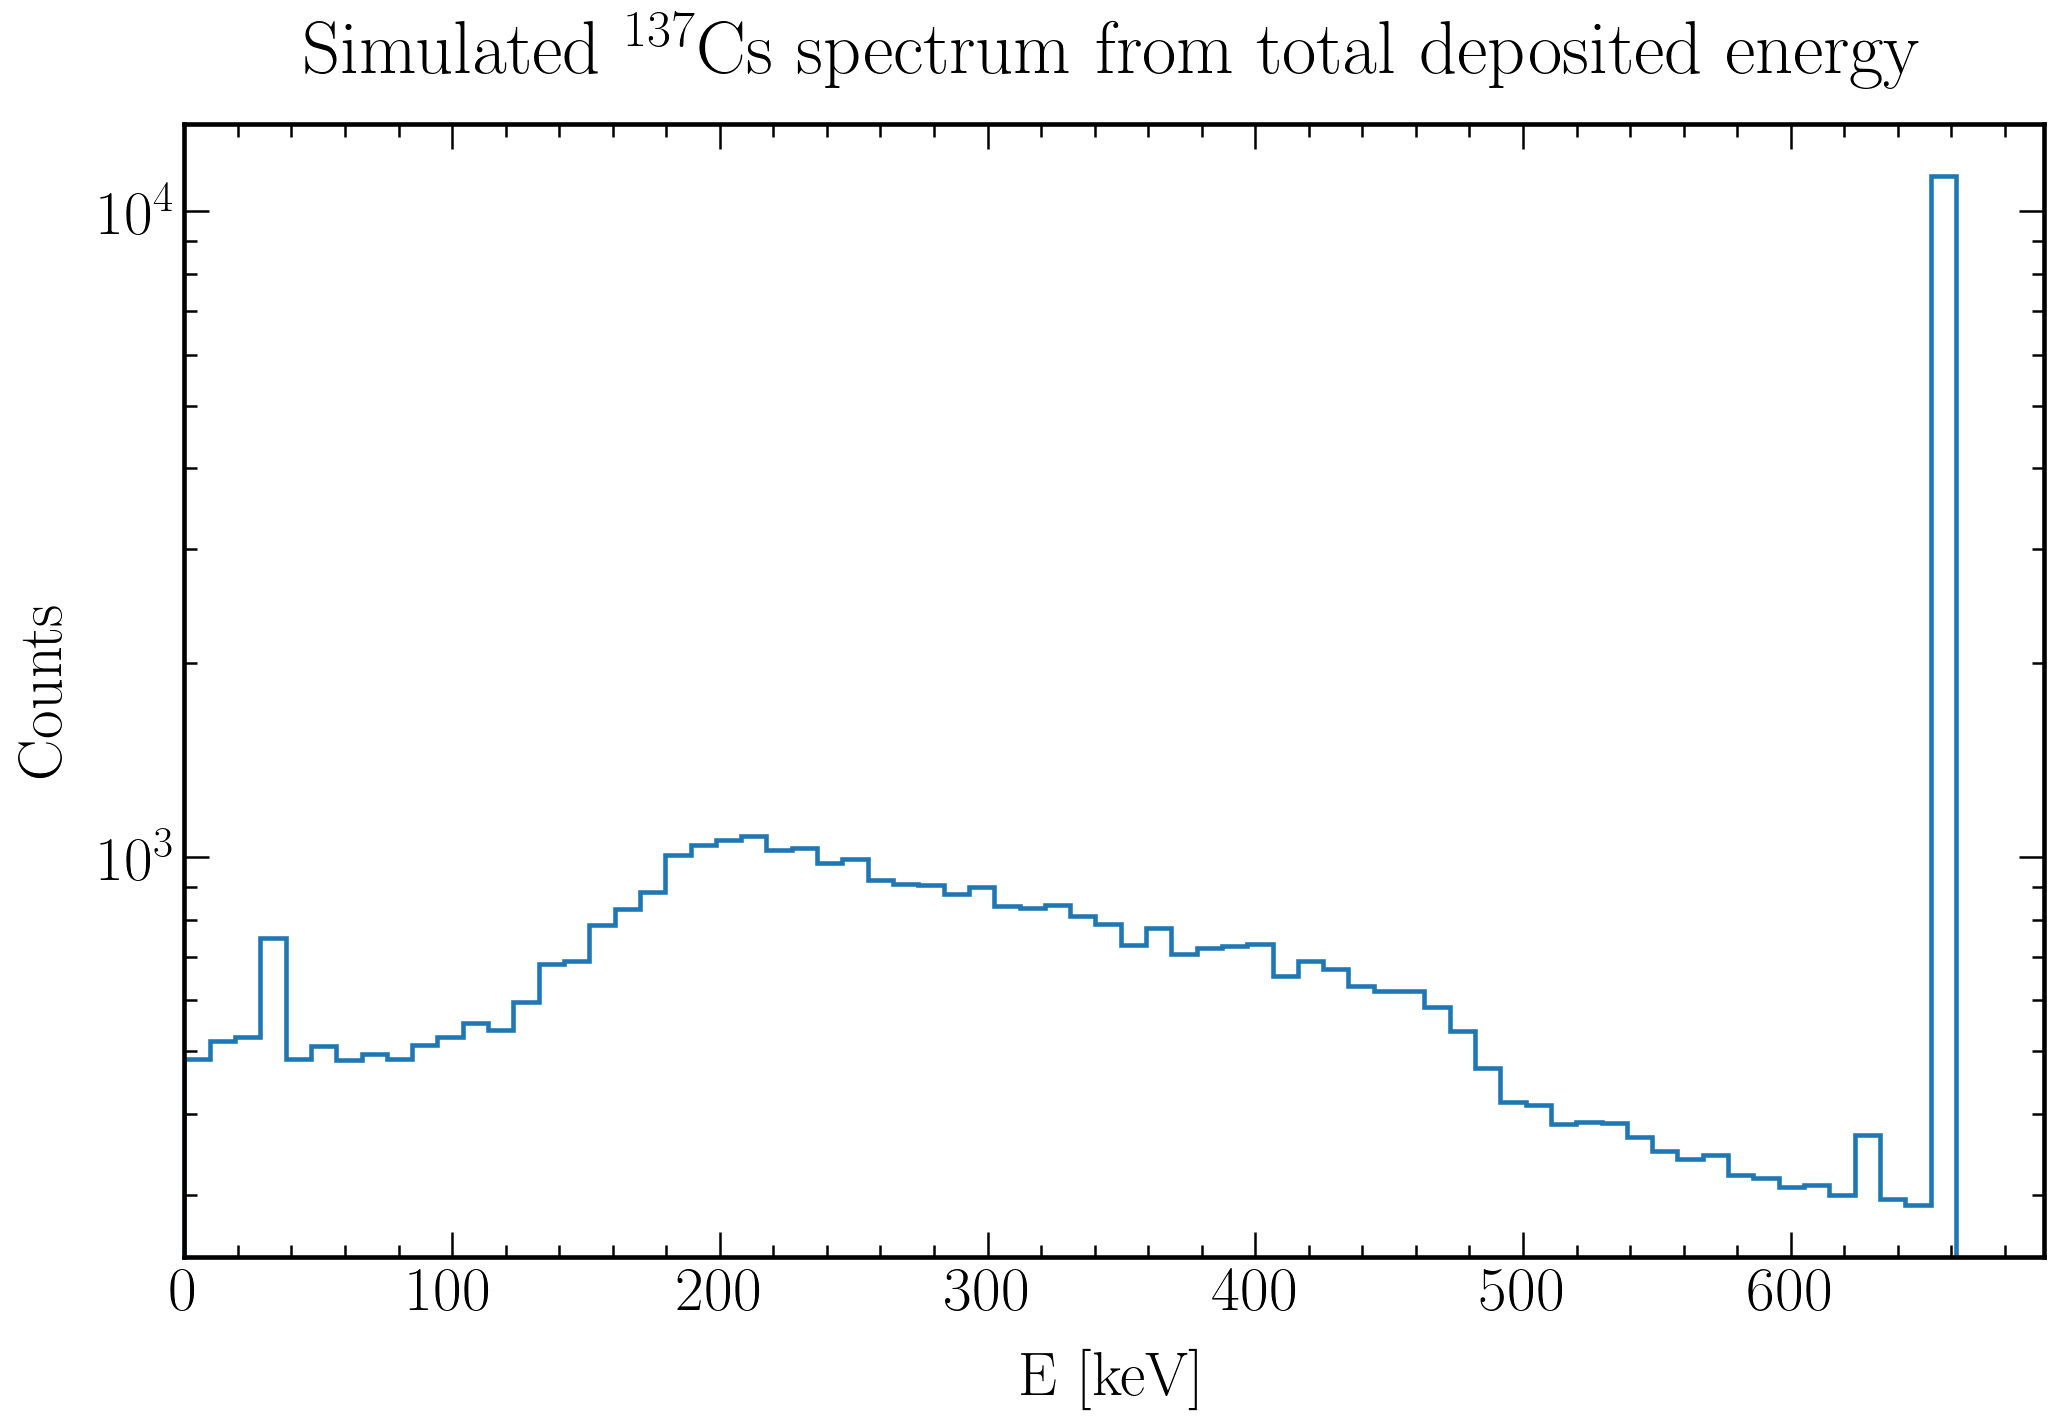

In [19]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
if Clustered == True:
    n, bins, patches = plt.hist(_chunk_collect.ed, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)
else:
    n, bins, patches = plt.hist(_chunk_collect.etot, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Simulated '+isotope_name_fancy+' spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

#plt.text(662-10-10, 0.7*int(max(n)), "662 keV\n$\gamma$ peak", fontsize = label_size, horizontalalignment='right', verticalalignment='top', multialignment='right', color = 'red')

# Axes ---> Range
plt.xlim(left = 0)
#plt.ylim(0,16000)
#plt.xlim(left=0)
'''plt.ylim(bottom=2500)
plt.ylim(top=150000)'''
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_totalenergy_spectrum.png")

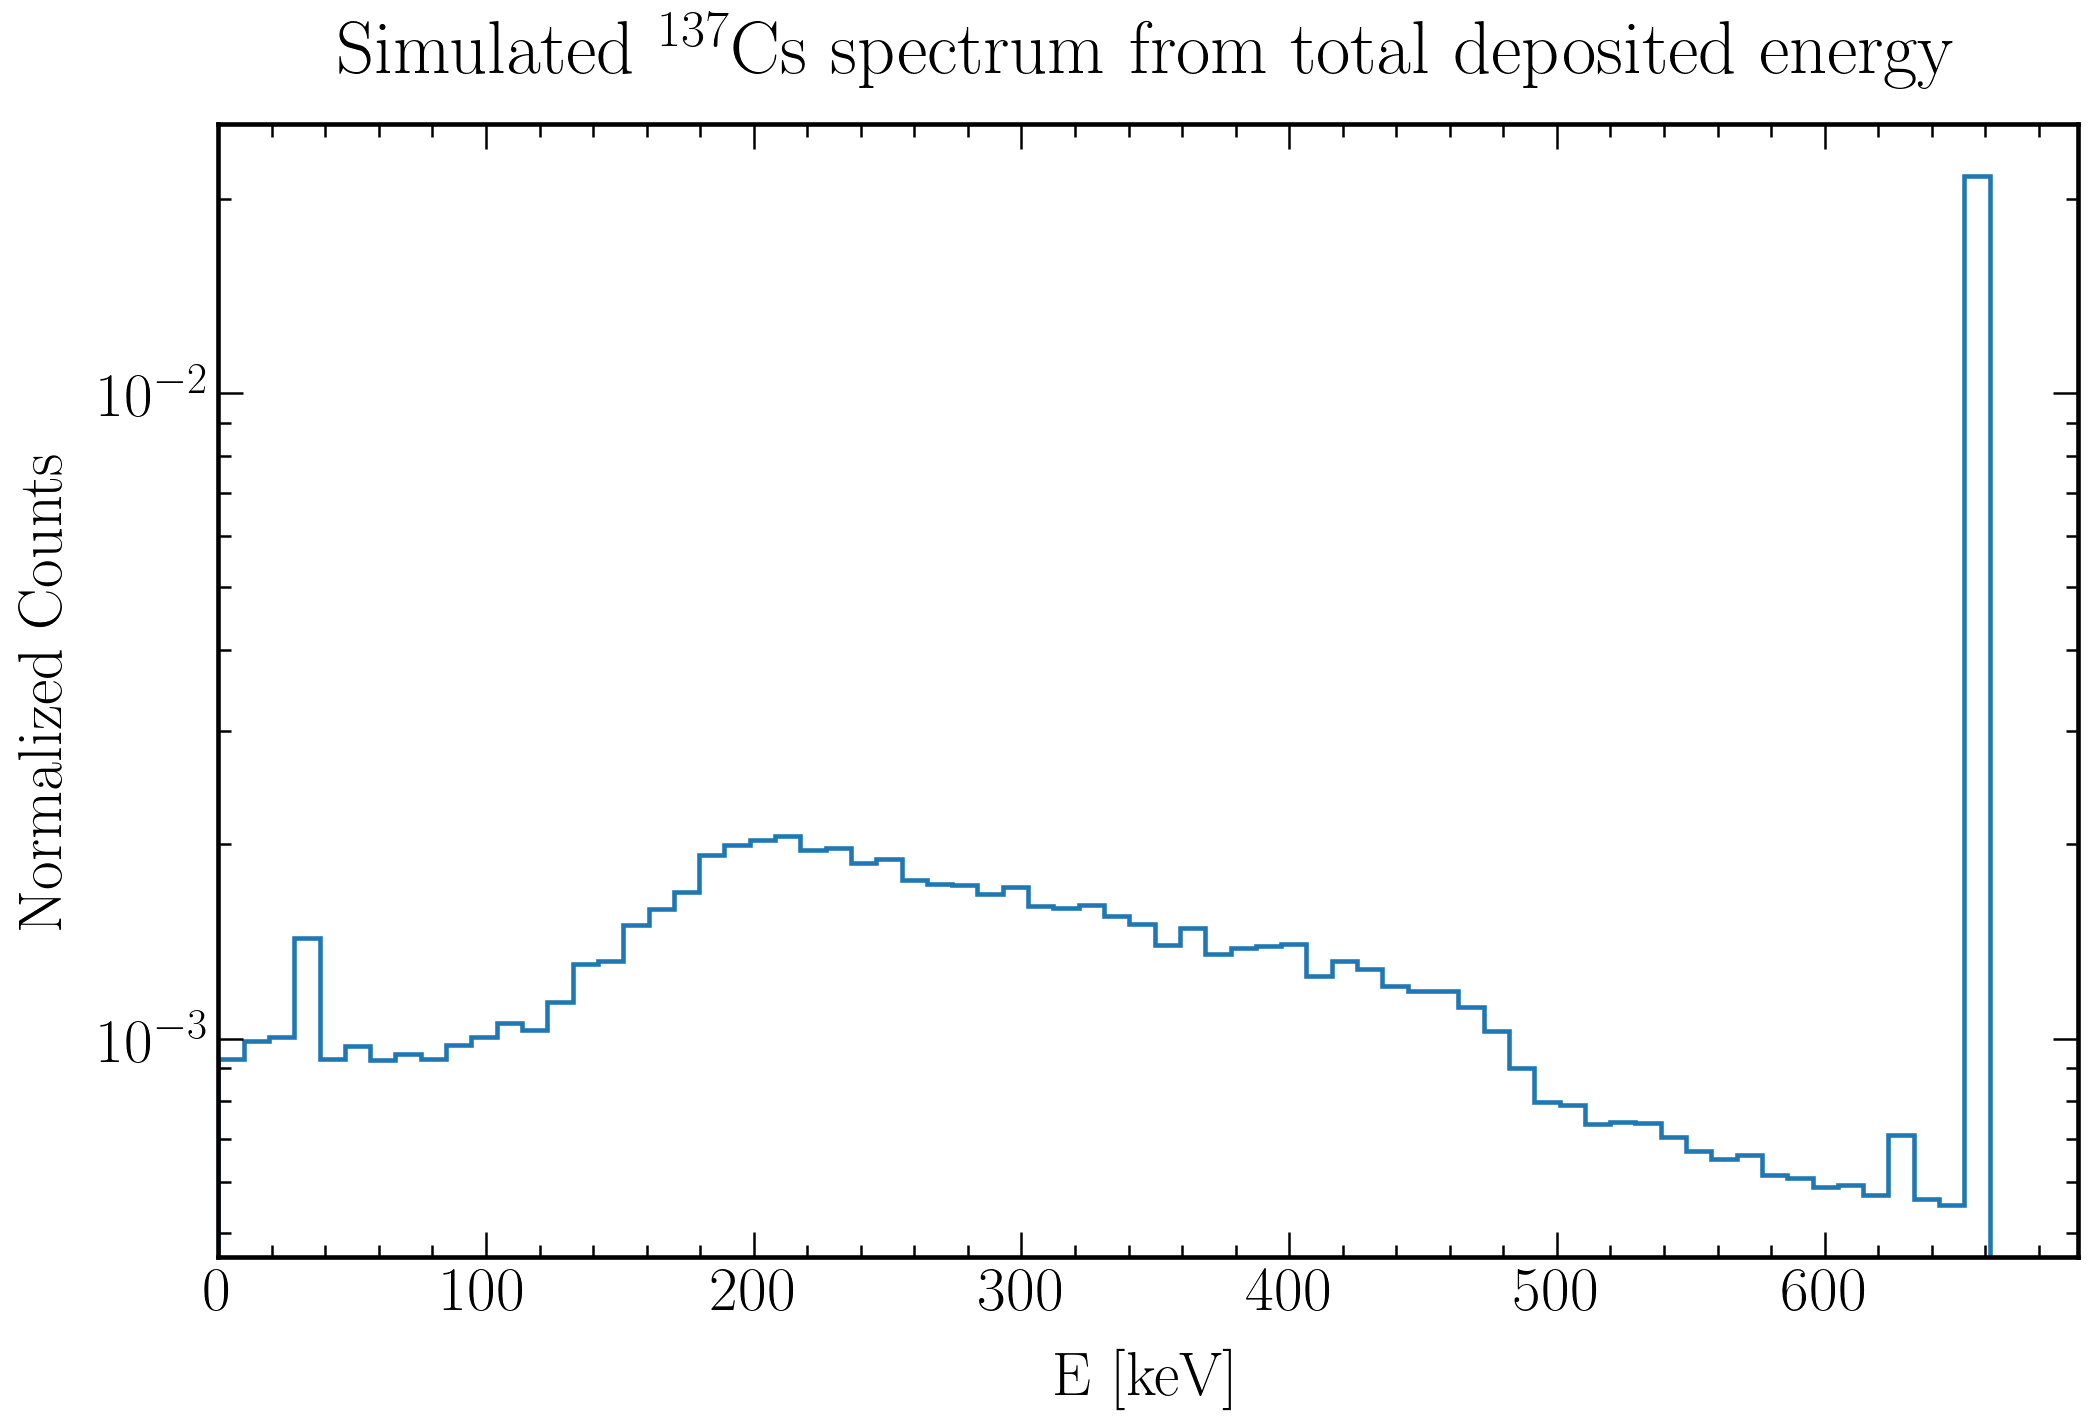

In [20]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
if Clustered == True:
    n, bins, patches = plt.hist(_chunk_collect.ed, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2, density = True)
else:
    n, bins, patches = plt.hist(_chunk_collect.etot, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2, density = True)

plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Simulated '+isotope_name_fancy+' spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

#plt.text(662-10-10, 0.7*max(n), "662 keV\n$\gamma$ peak", fontsize = label_size, horizontalalignment='right', verticalalignment='top', multialignment='right', color = 'red')

# Axes ---> Range
plt.xlim(left = 0)
#plt.ylim(2e-4,3e-2)
#plt.xlim(left=0)
'''plt.ylim(bottom=2500)
plt.ylim(top=150000)'''
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_totalenergy_spectrum_normed.png")

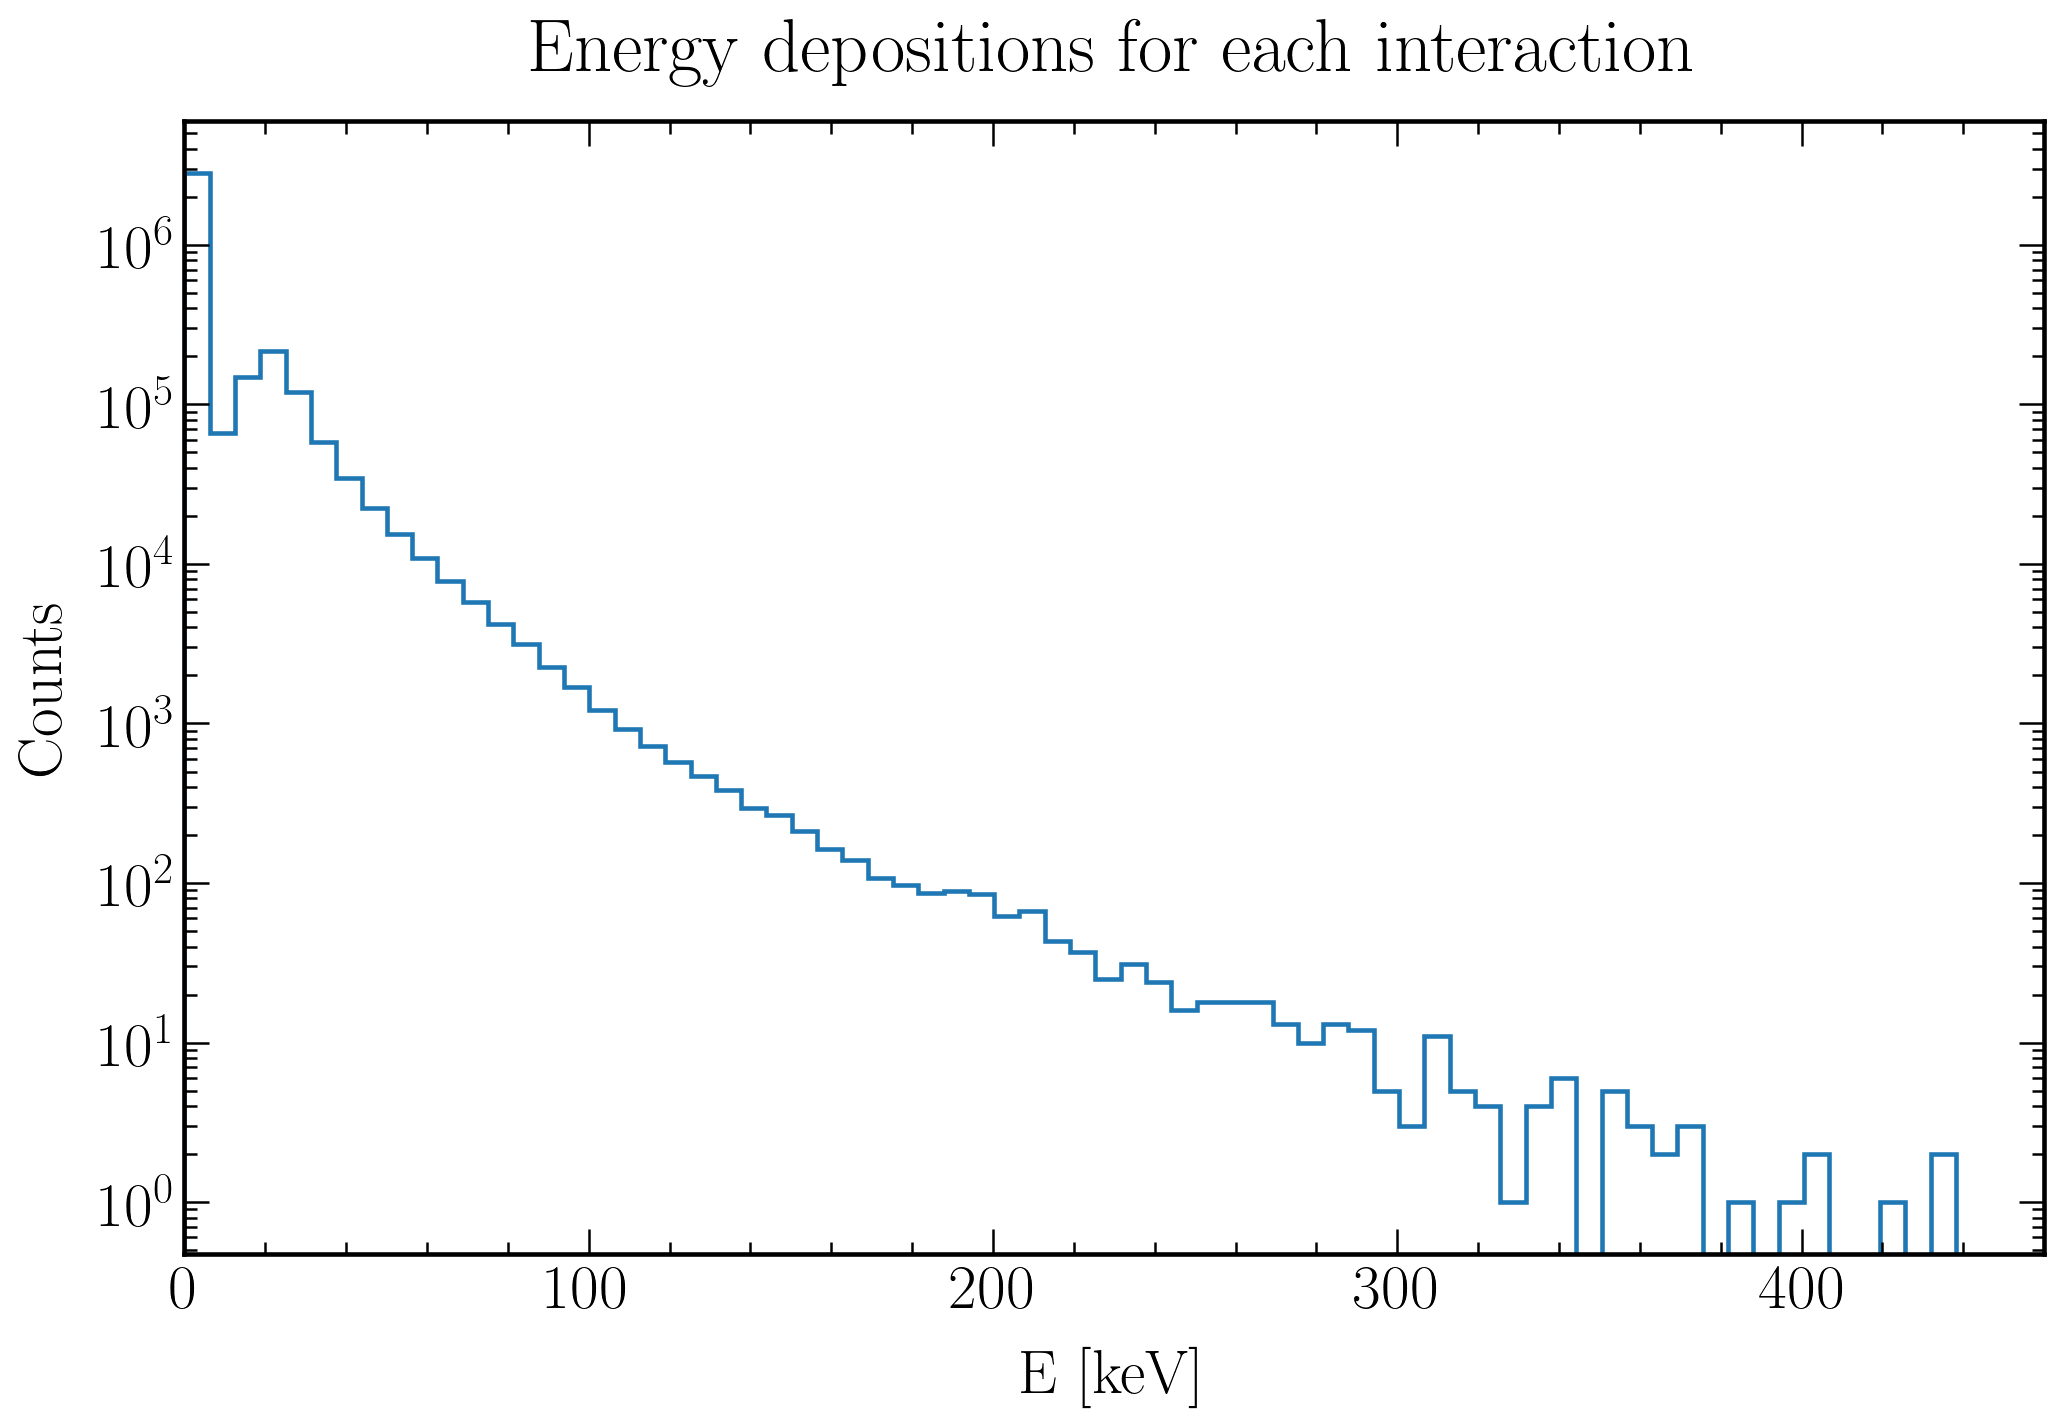

In [21]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(ed_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
if Clustered == False:
    plt.title('Energy depositions for each interaction', fontsize = title_size, pad = title_pad)
if Clustered == True:
    plt.title('Energy depositions for each event', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,700)
#plt.ylim(0,16000)
plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_ed_spectrum.png")

### Event positions

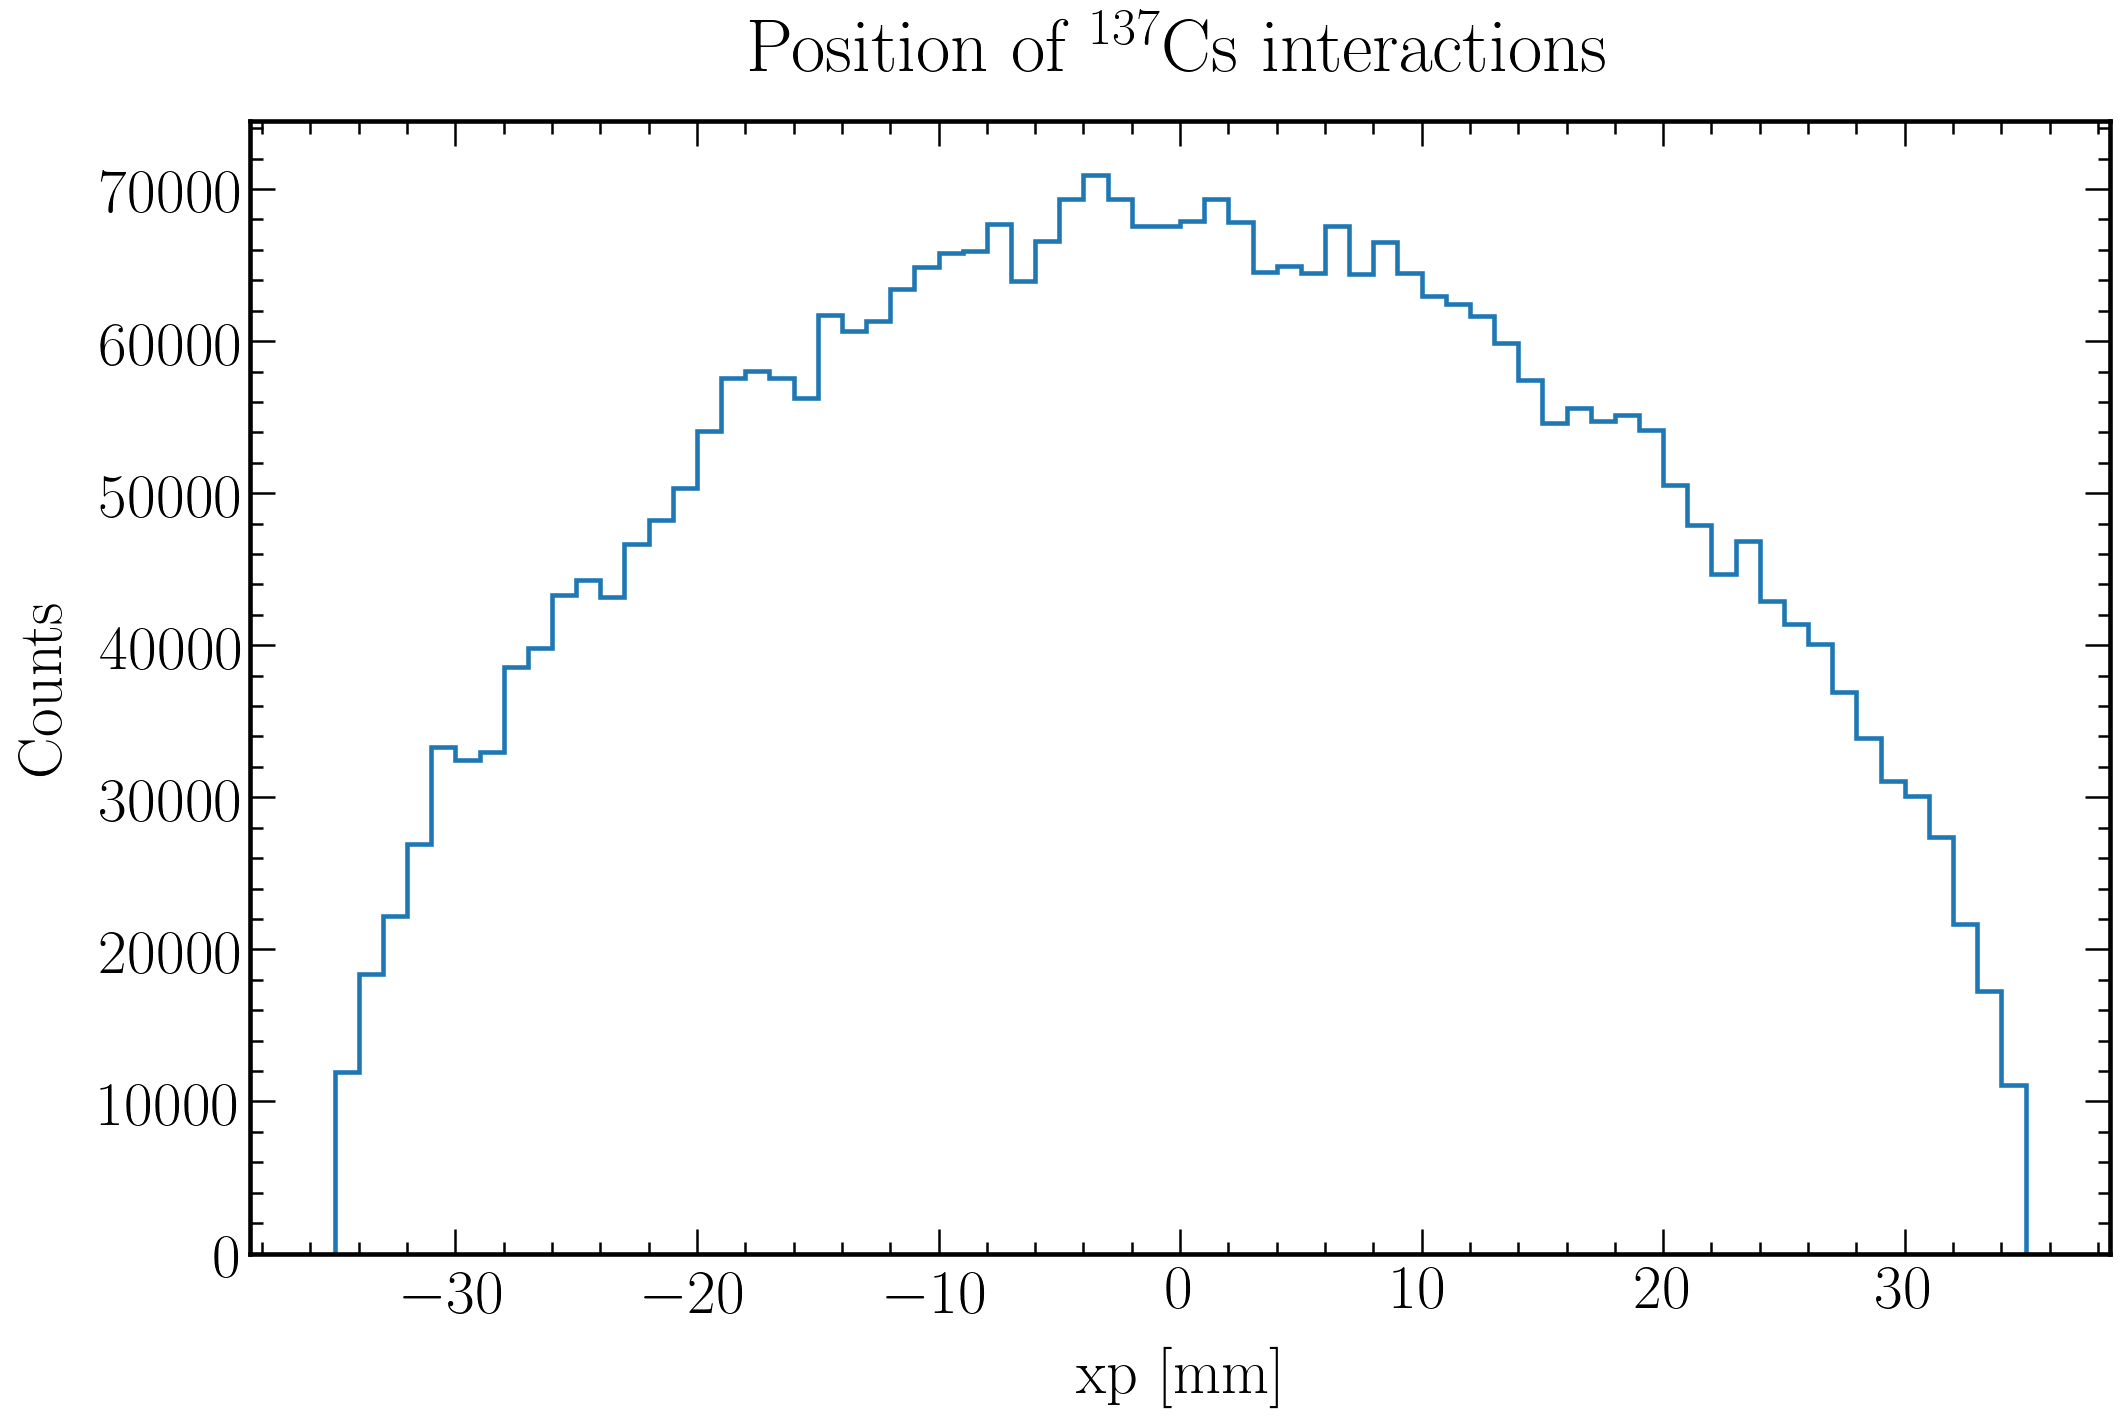

In [22]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(xp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('xp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_xp_spectrum.png")

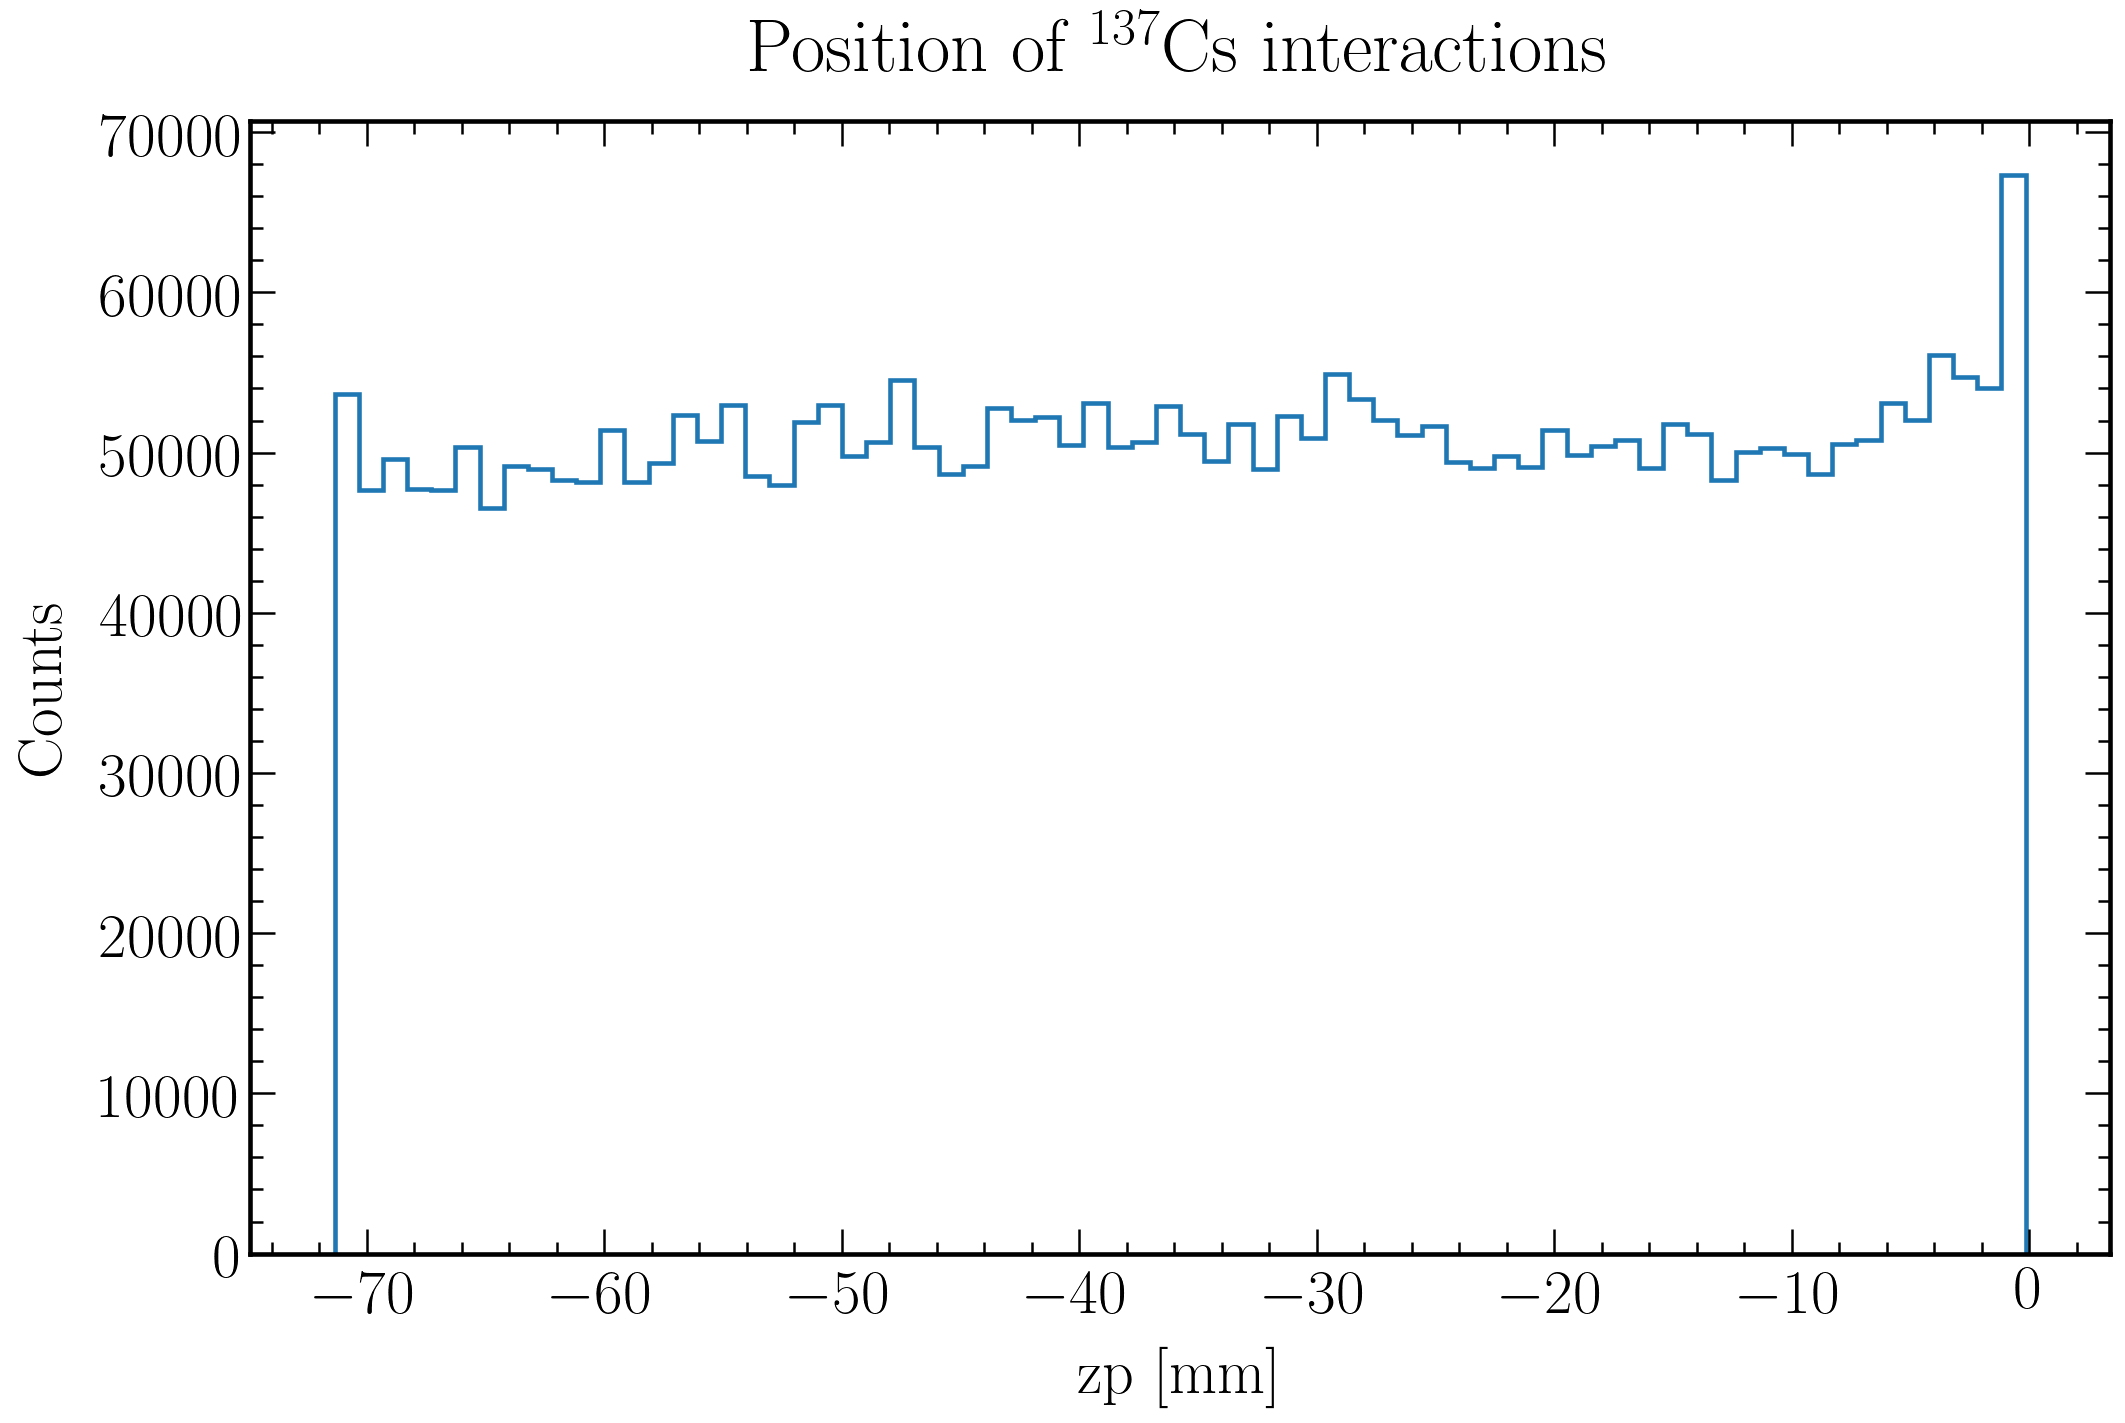

In [23]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(zp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('zp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_zp_spectrum.png")

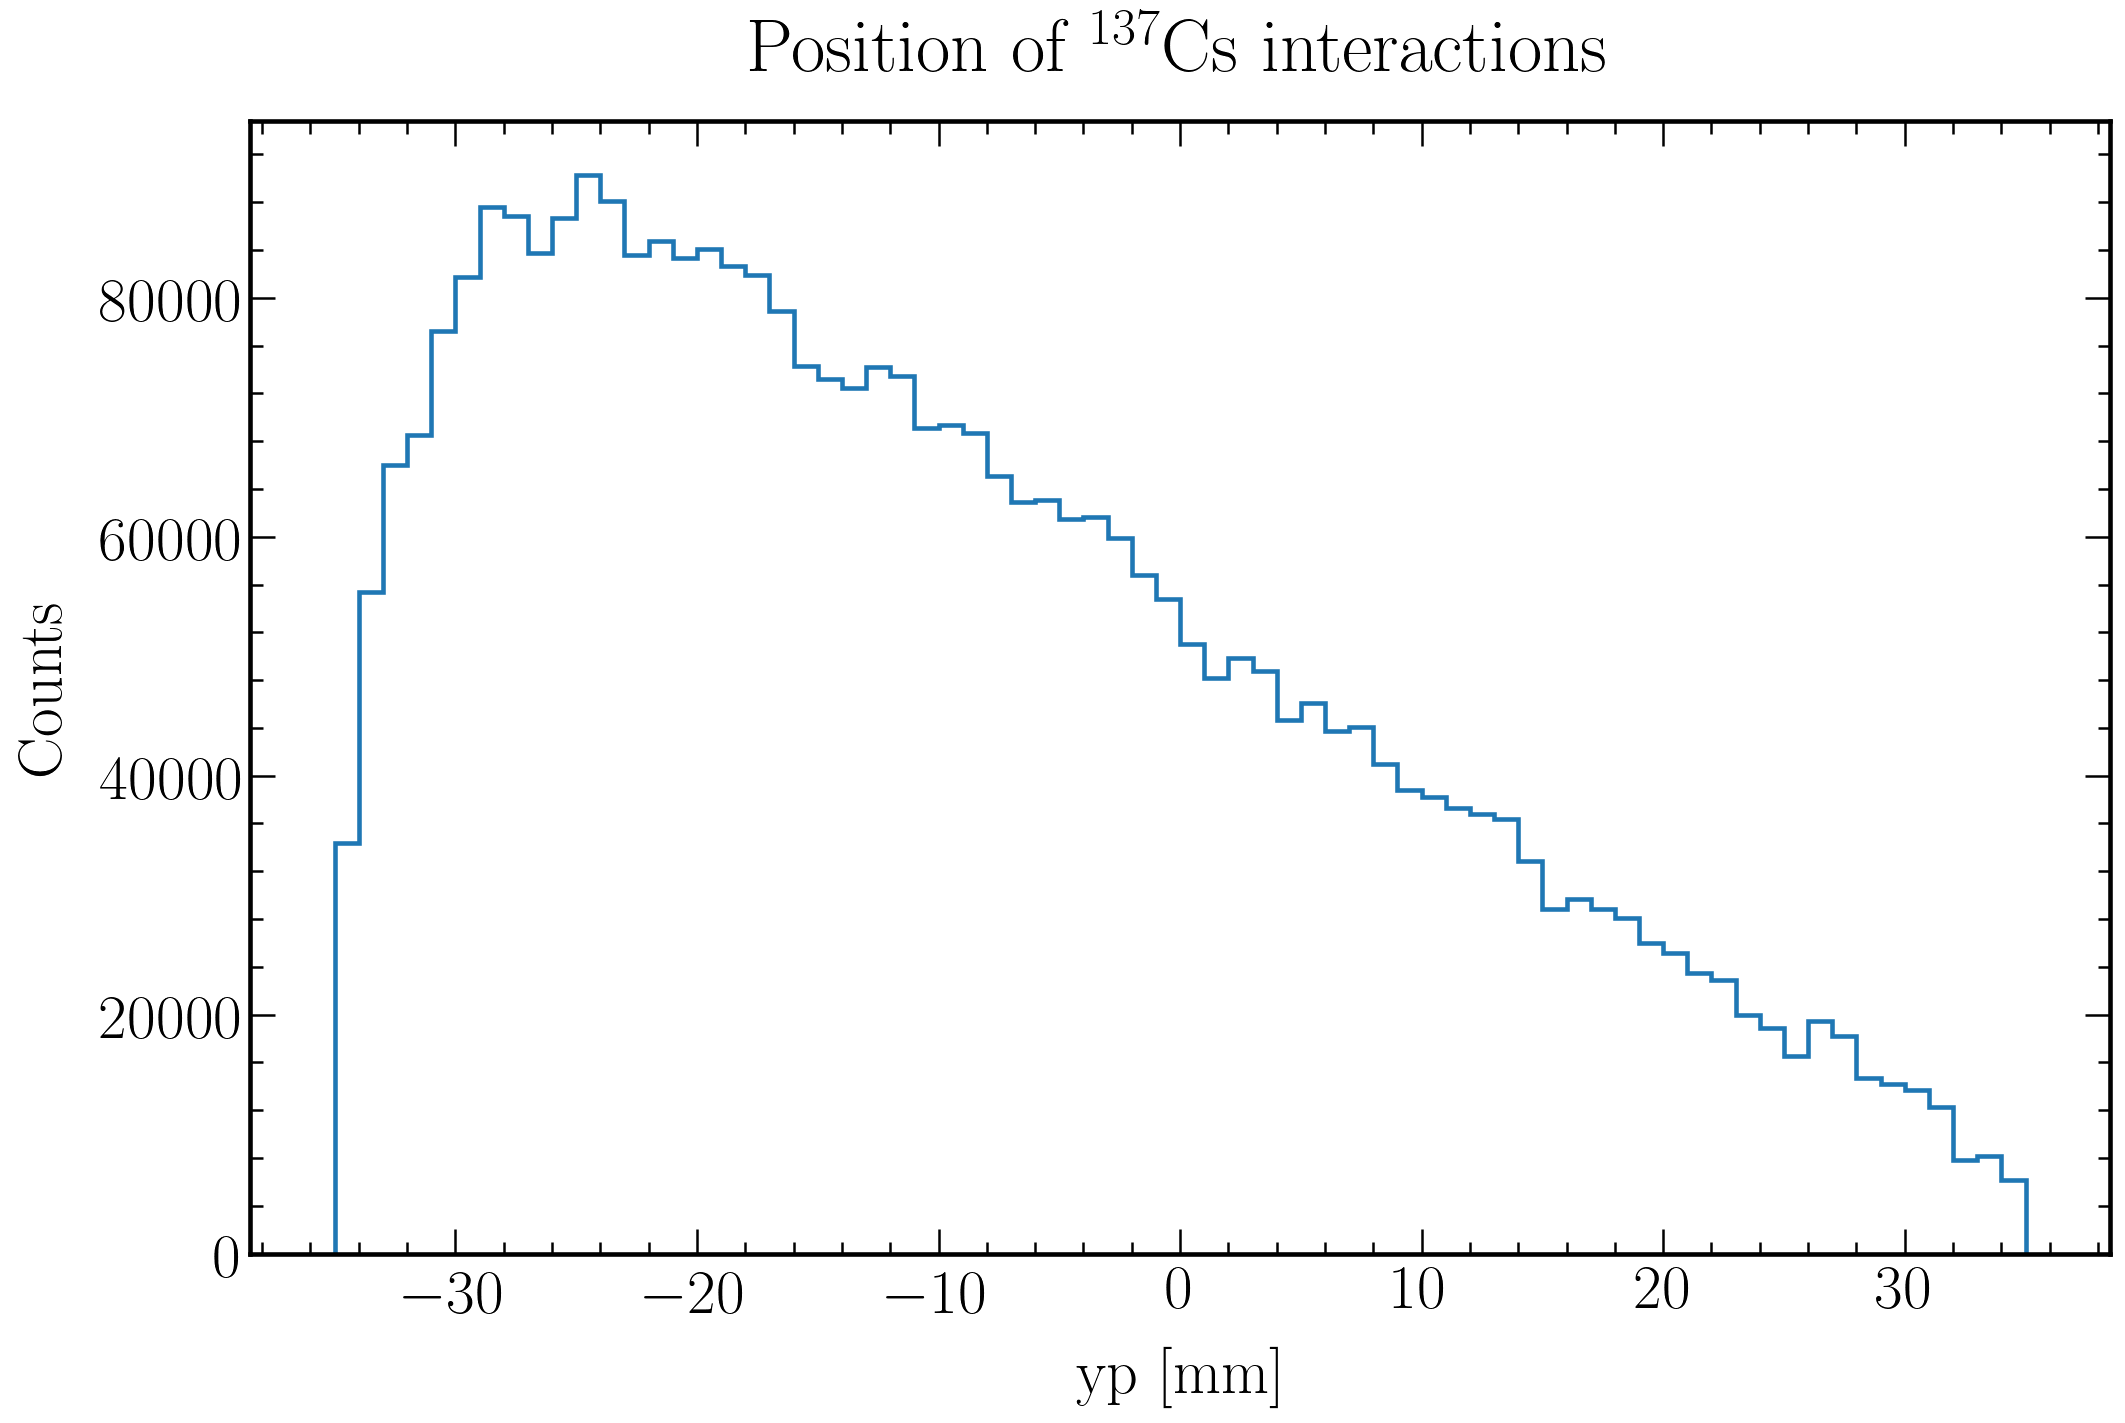

In [24]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum.png")

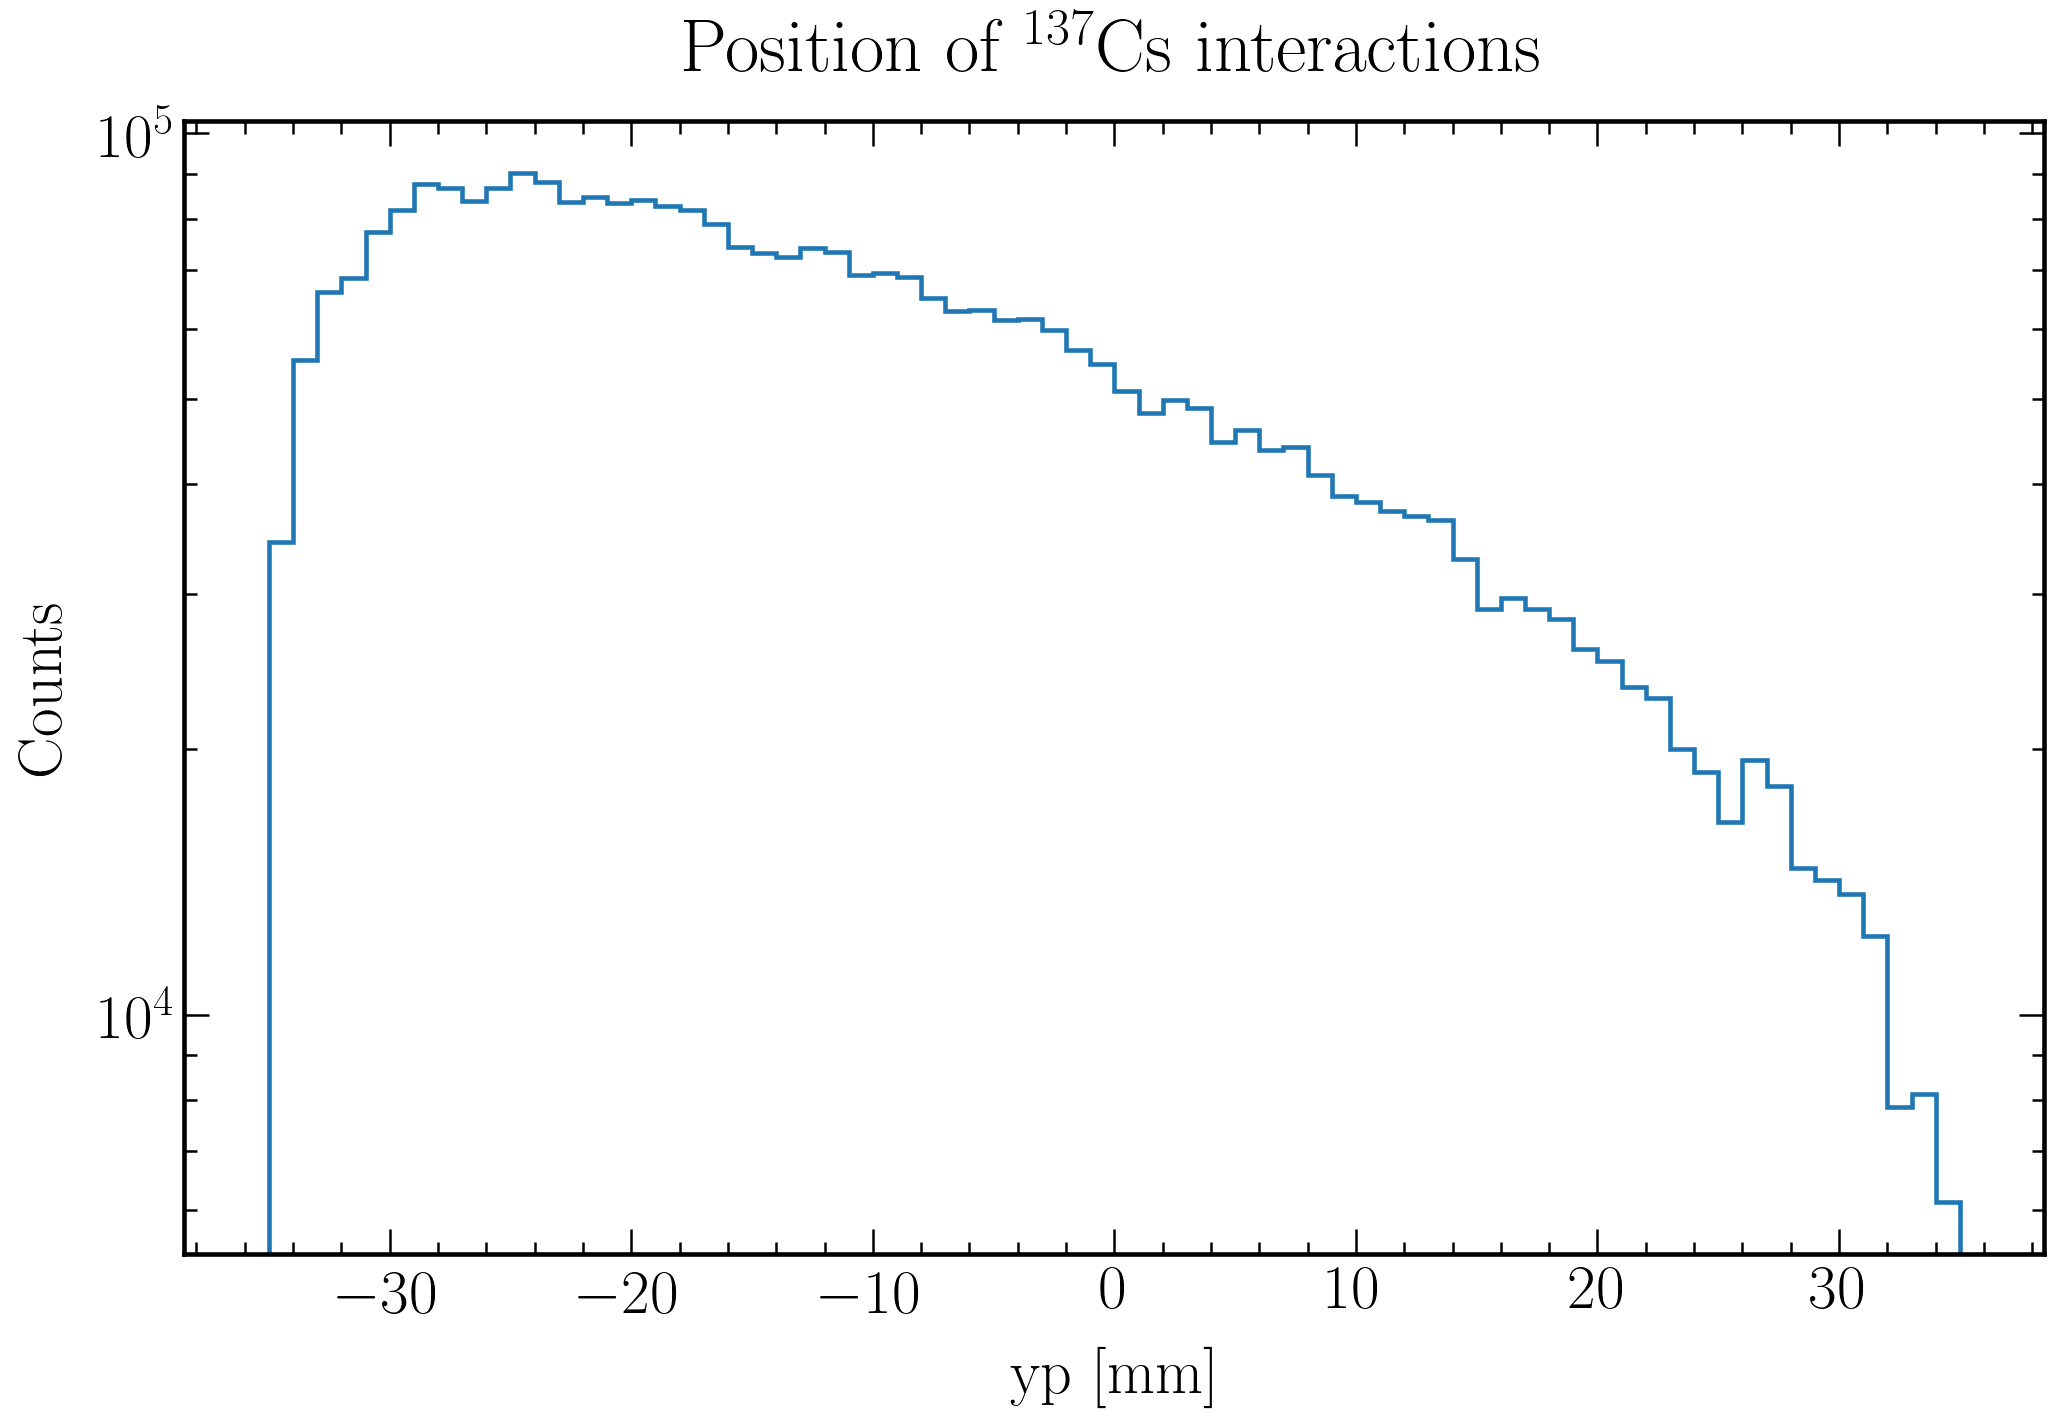

In [25]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_log.png")

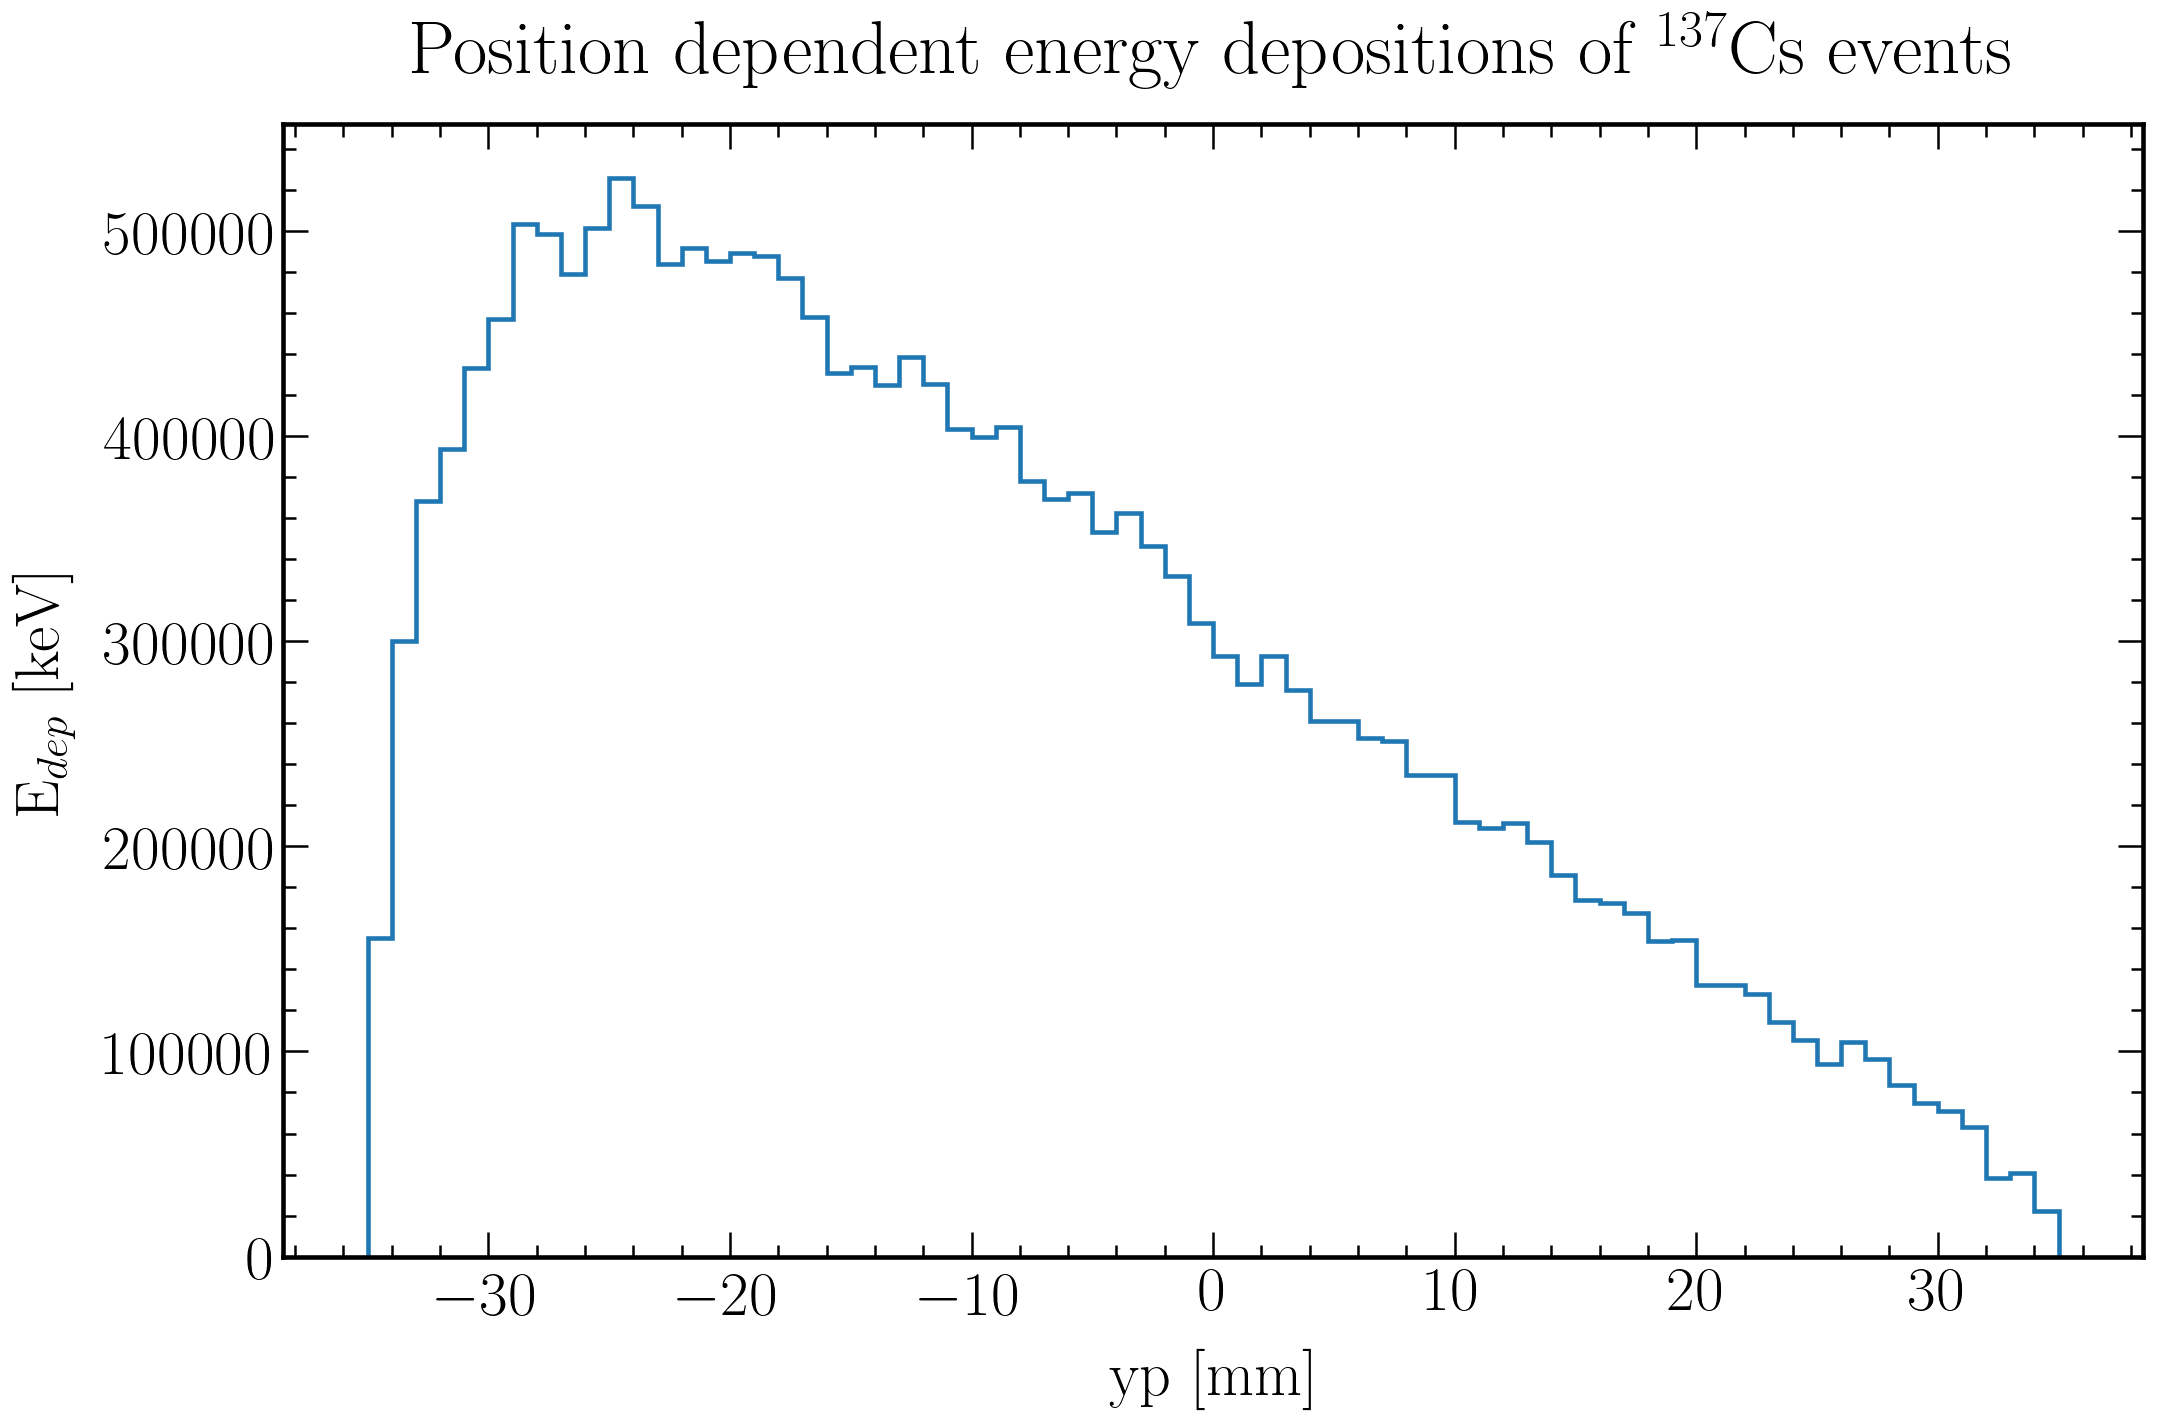

In [26]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, weights = ed_flat, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('E$_{dep}$ [keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Position dependent energy depositions of '+isotope_name_fancy+' events', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_ed-weighted.png")

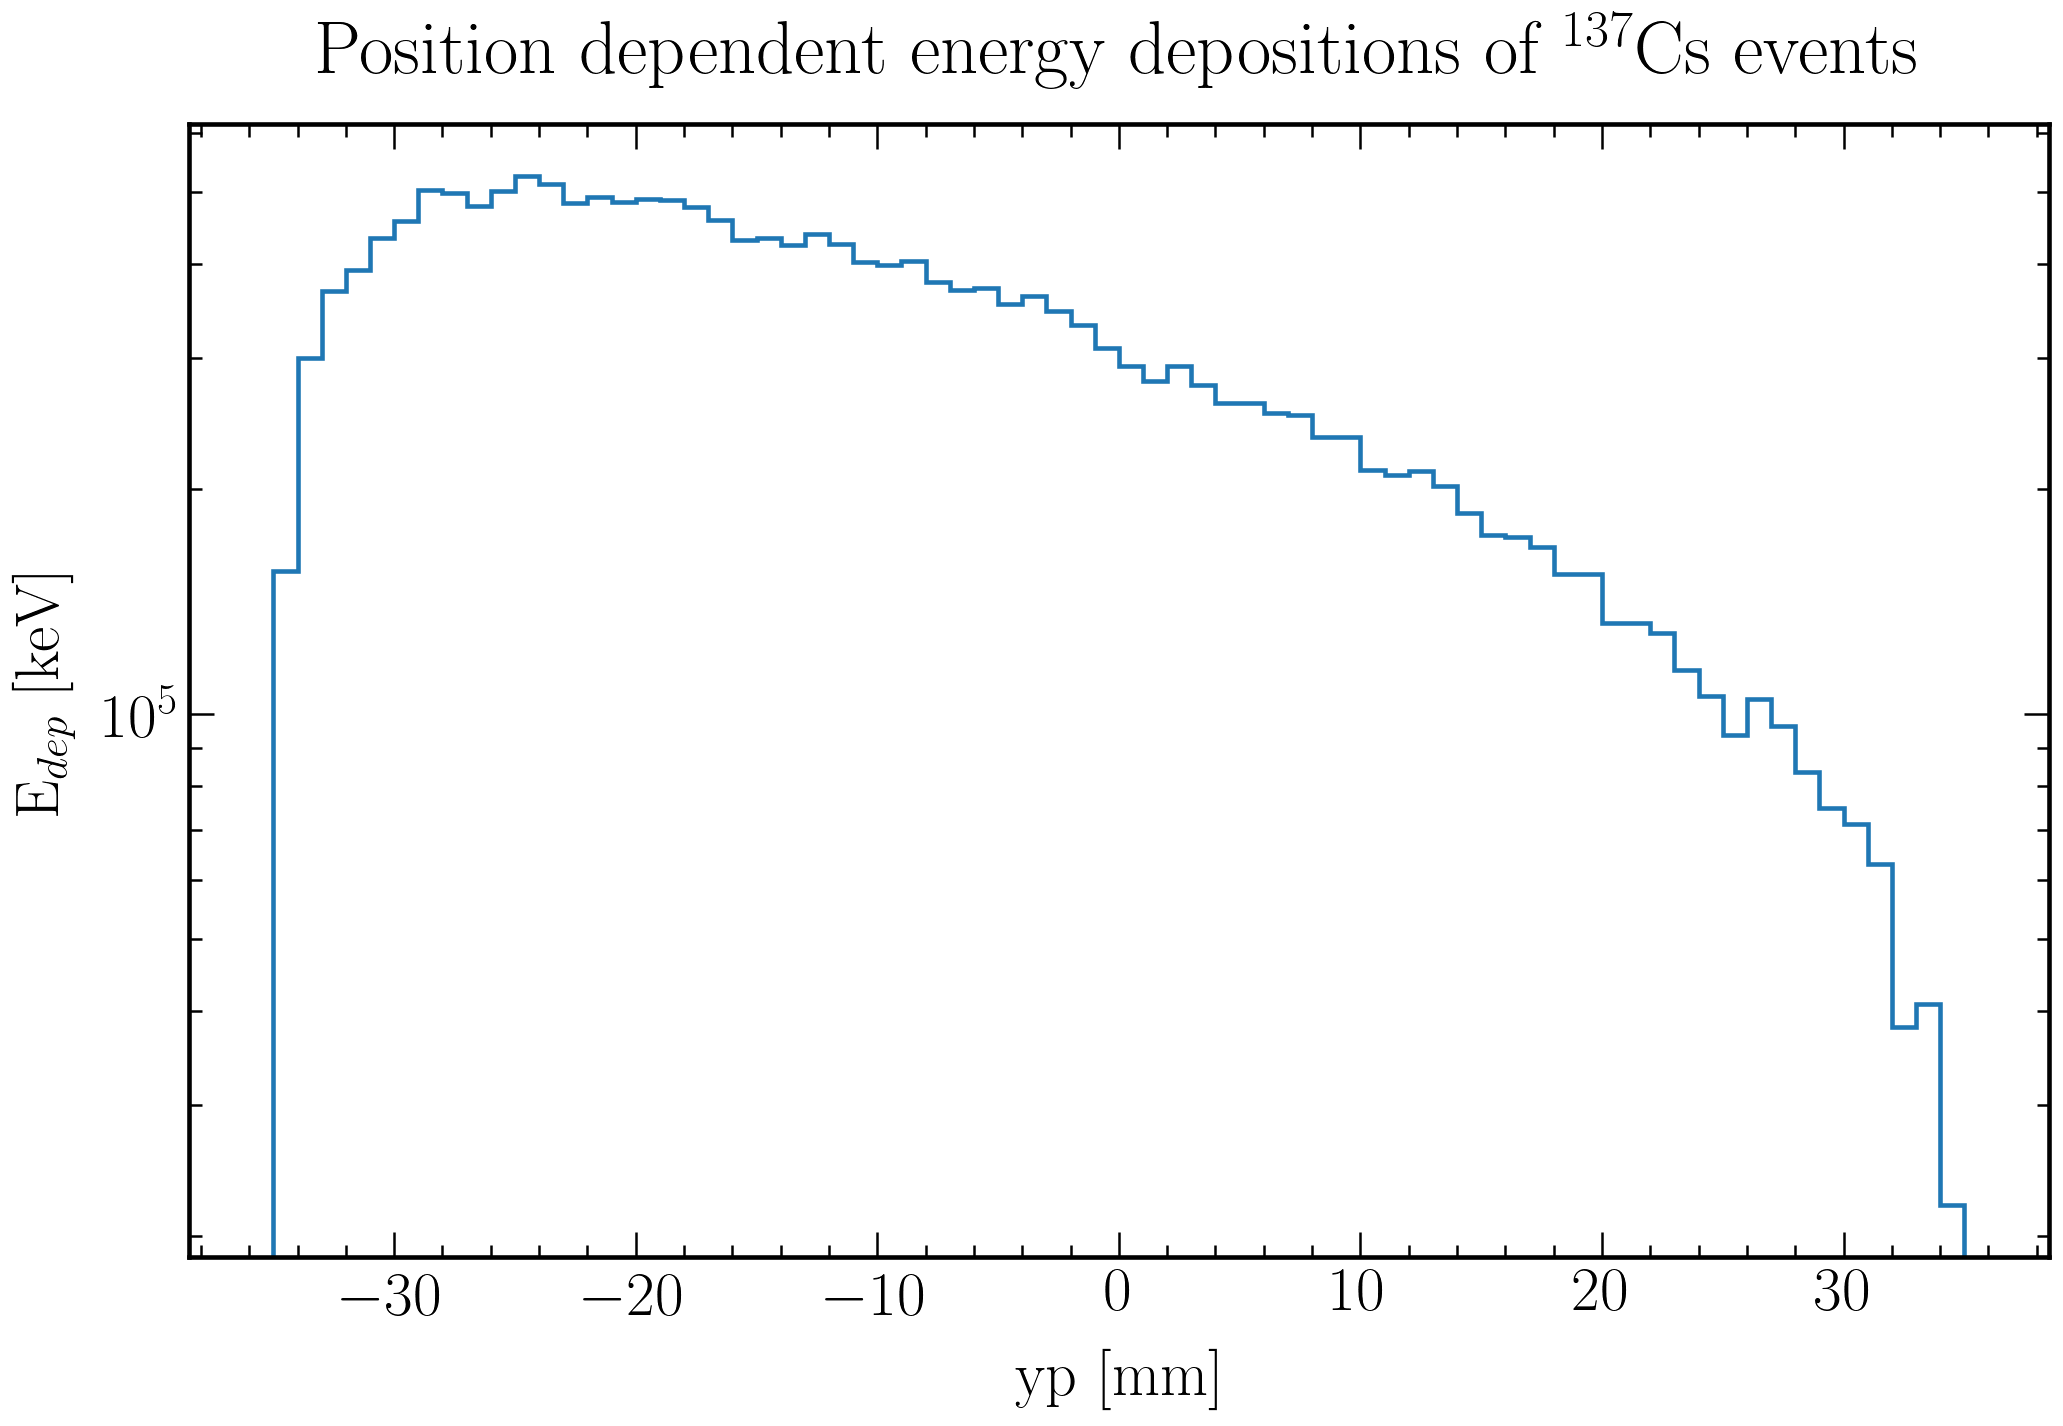

In [27]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, weights = ed_flat, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('E$_{dep}$ [keV]', fontsize = label_size, labelpad = label_pad)
plt.title('Position dependent energy depositions of '+isotope_name_fancy+' events', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_ed-weighted_log.png")

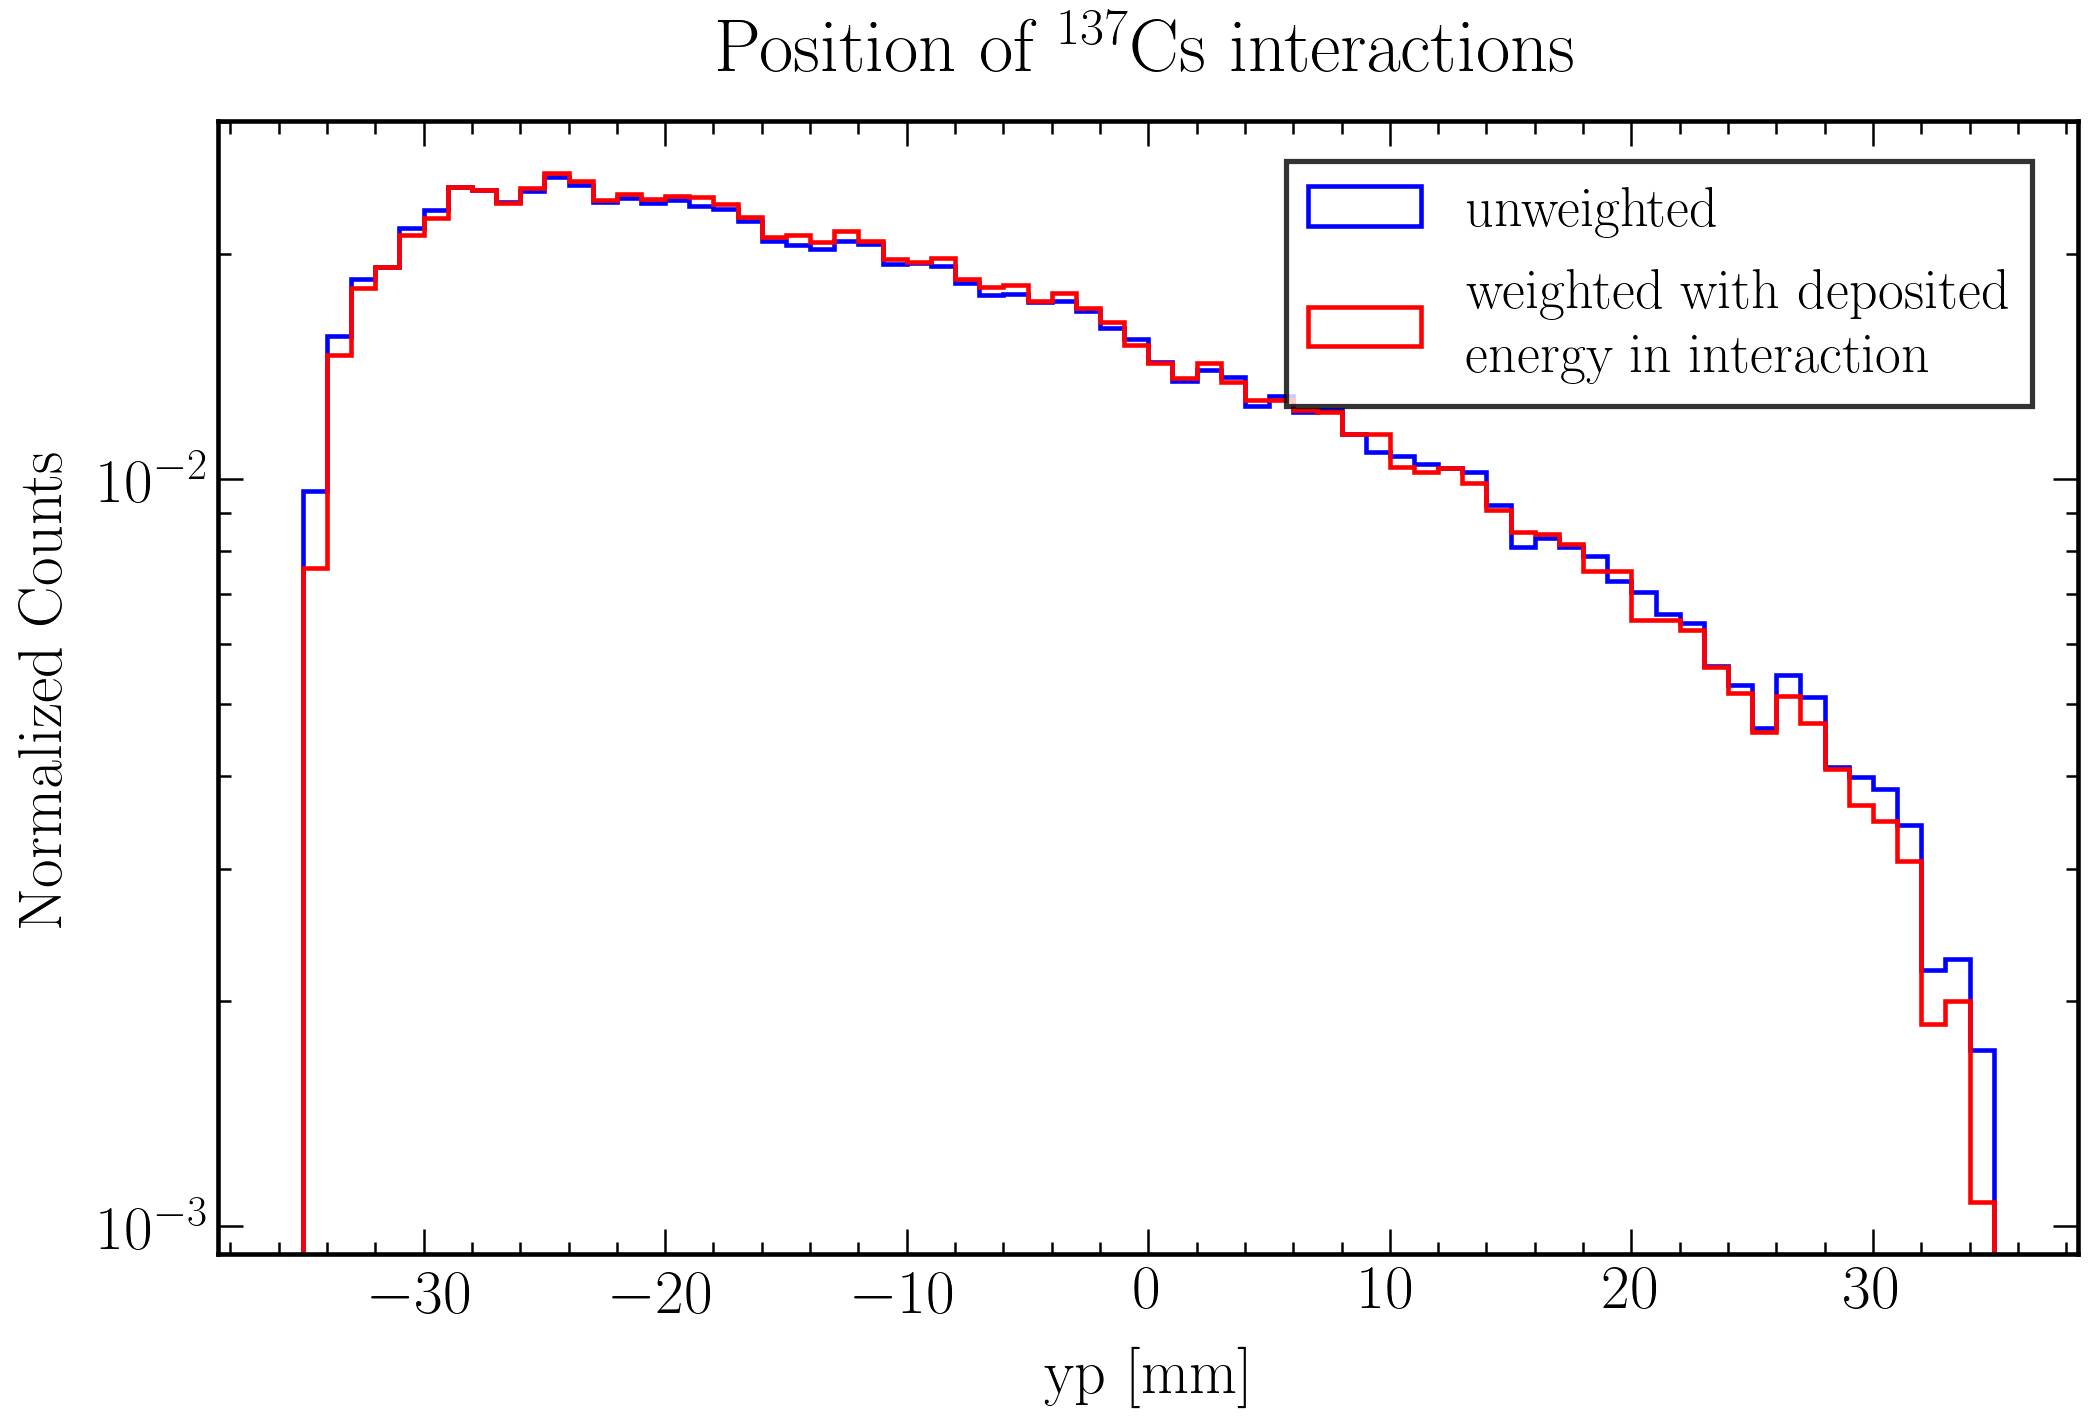

In [28]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat, 70, density = True, color='blue', histtype = 'step', linewidth = 2.2, label = 'unweighted')
n, bins, patches = plt.hist(yp_flat, 70, weights = ed_flat, density = True, color='red', histtype = 'step', linewidth = 2.2, label = 'weighted with deposited\nenergy in interaction')

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

# Legend
leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_comparison_log.png")

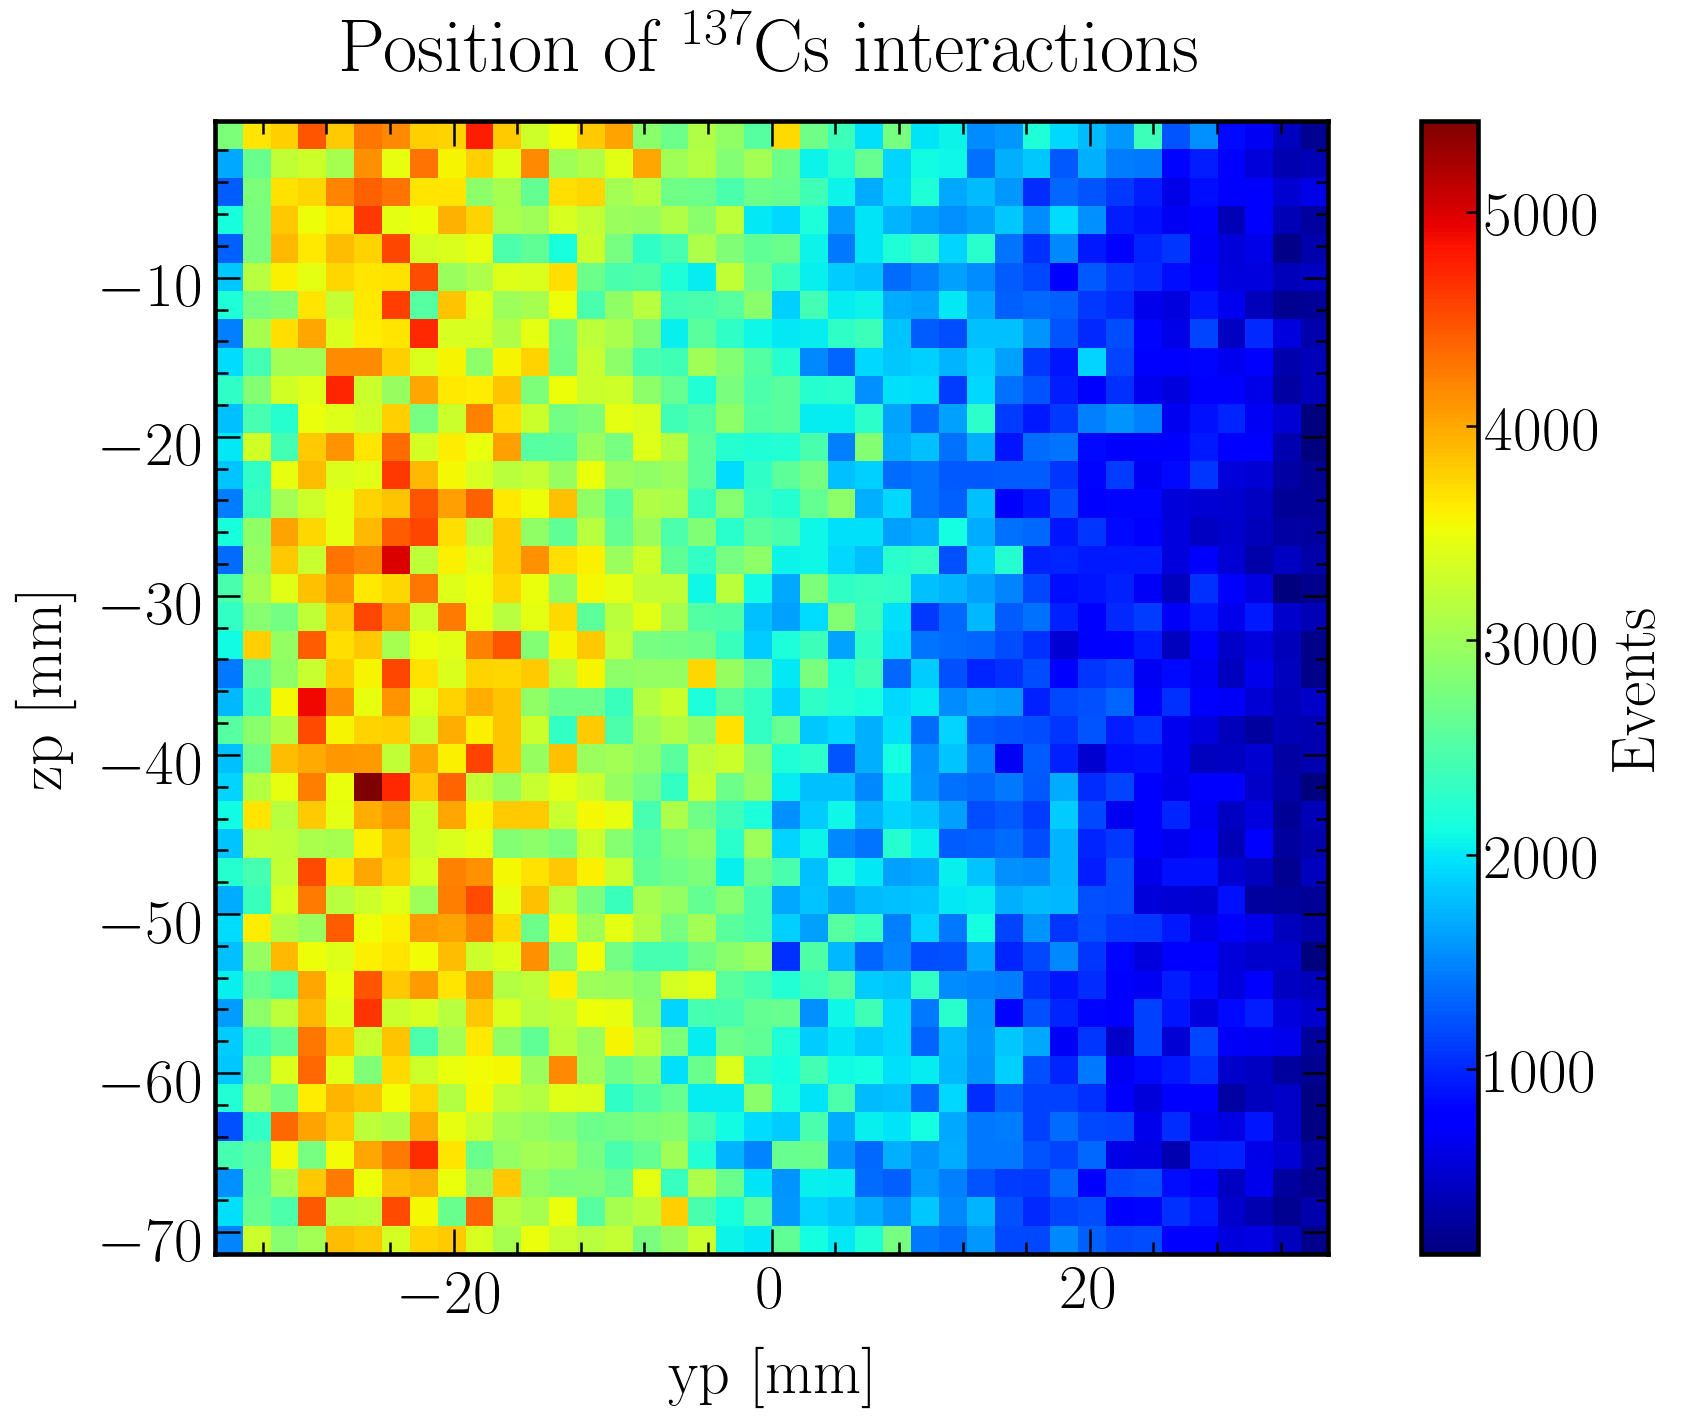

In [29]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(yp_flat, zp_flat, bins=40, cmap = 'jet')#, norm=LogNorm(), normed = True

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('zp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_zp.png")

In [30]:
if Clustered == True:

    #############################################
    ## Set plot styles:
    #############################################

    fig=plt.figure(figsize=(16, 10), dpi=150)

    # Text options
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # Labels
    label_size = 30 #25
    label_pad = 12 #10
    title_size = 36 #30
    title_pad = 24 #20

    # Axes Parameters
    axes = plt.gca()
    axes.tick_params(axis='both') 

    # Axes ---> Linewidth
    for axis in ['top','bottom','left','right']:
        axes.spines[axis].set_linewidth(2.2)

    # Axes ---> Ticks
    axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    axes.yaxis.set_minor_locator(AutoMinorLocator(5))
    plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
    plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

    # Grid
    #plt.grid(True)

    #############################################
    ## Plot specific settings and plot data
    #############################################

    # Data plot
    plt.hist2d(yp_flat, zp_flat, bins=40, vmin=0, vmax=900, cmap = 'jet')#, norm=LogNorm(), normed = True

    plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
    plt.ylabel('zp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
    plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

    plt.gca().set_aspect('equal', adjustable='box')

    # Colorbar
    cbar = plt.colorbar()
    cbar.outline.set_linewidth(2.2)
    cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
    cbar.set_label(label='Events', fontsize=label_size) # Normalized 

    # Axes ---> Range
    #plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
    #plt.ylim(0,16000)
    #plt.xlim(left=0)
    #plt.yscale('log', nonposy='clip')

    plt.show()

    fig.savefig(filenameprefix+"_yp_zp_scaled.png")

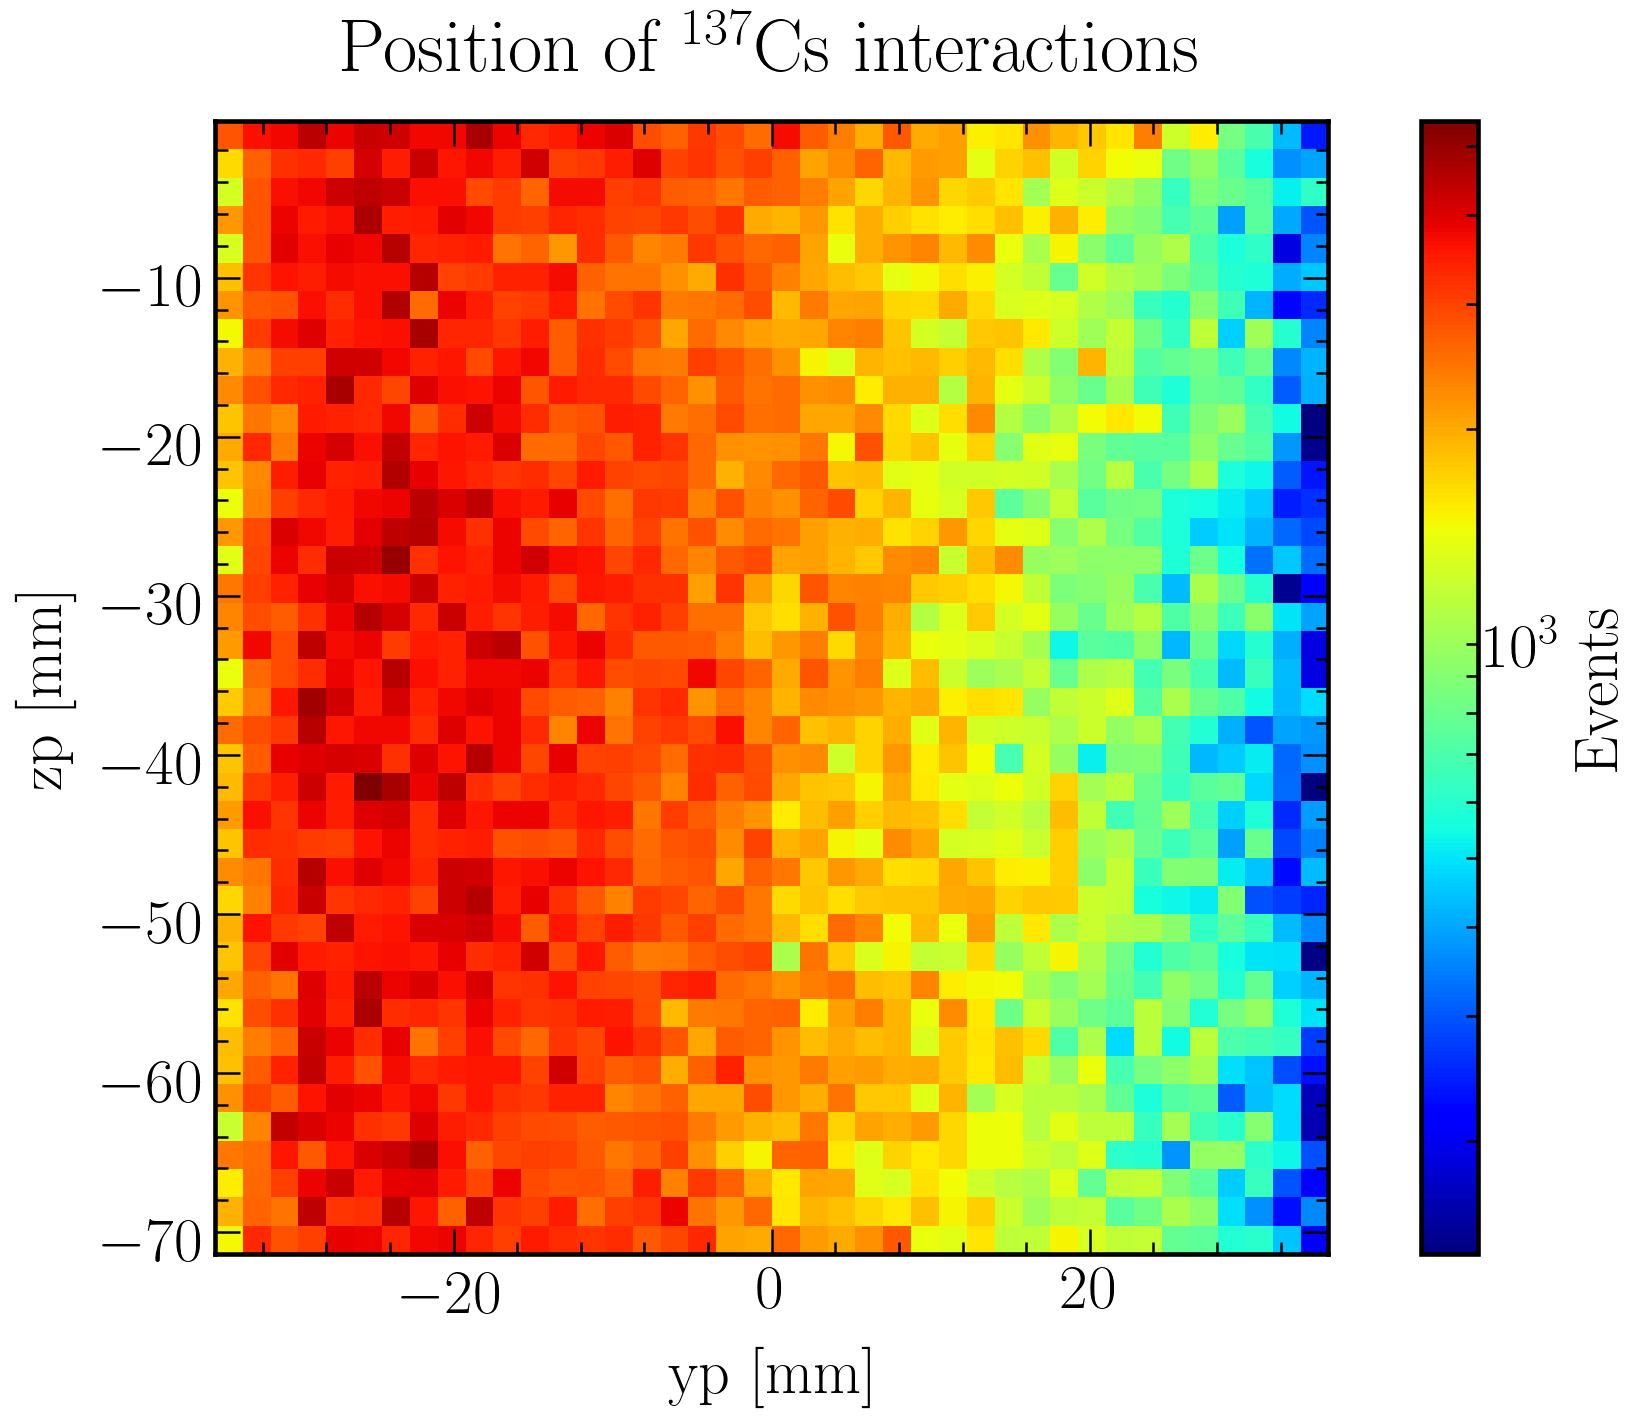

In [31]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(yp_flat, zp_flat, bins=40, cmap = 'jet', norm=LogNorm())#, normed = True

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('zp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_zp_log.png")

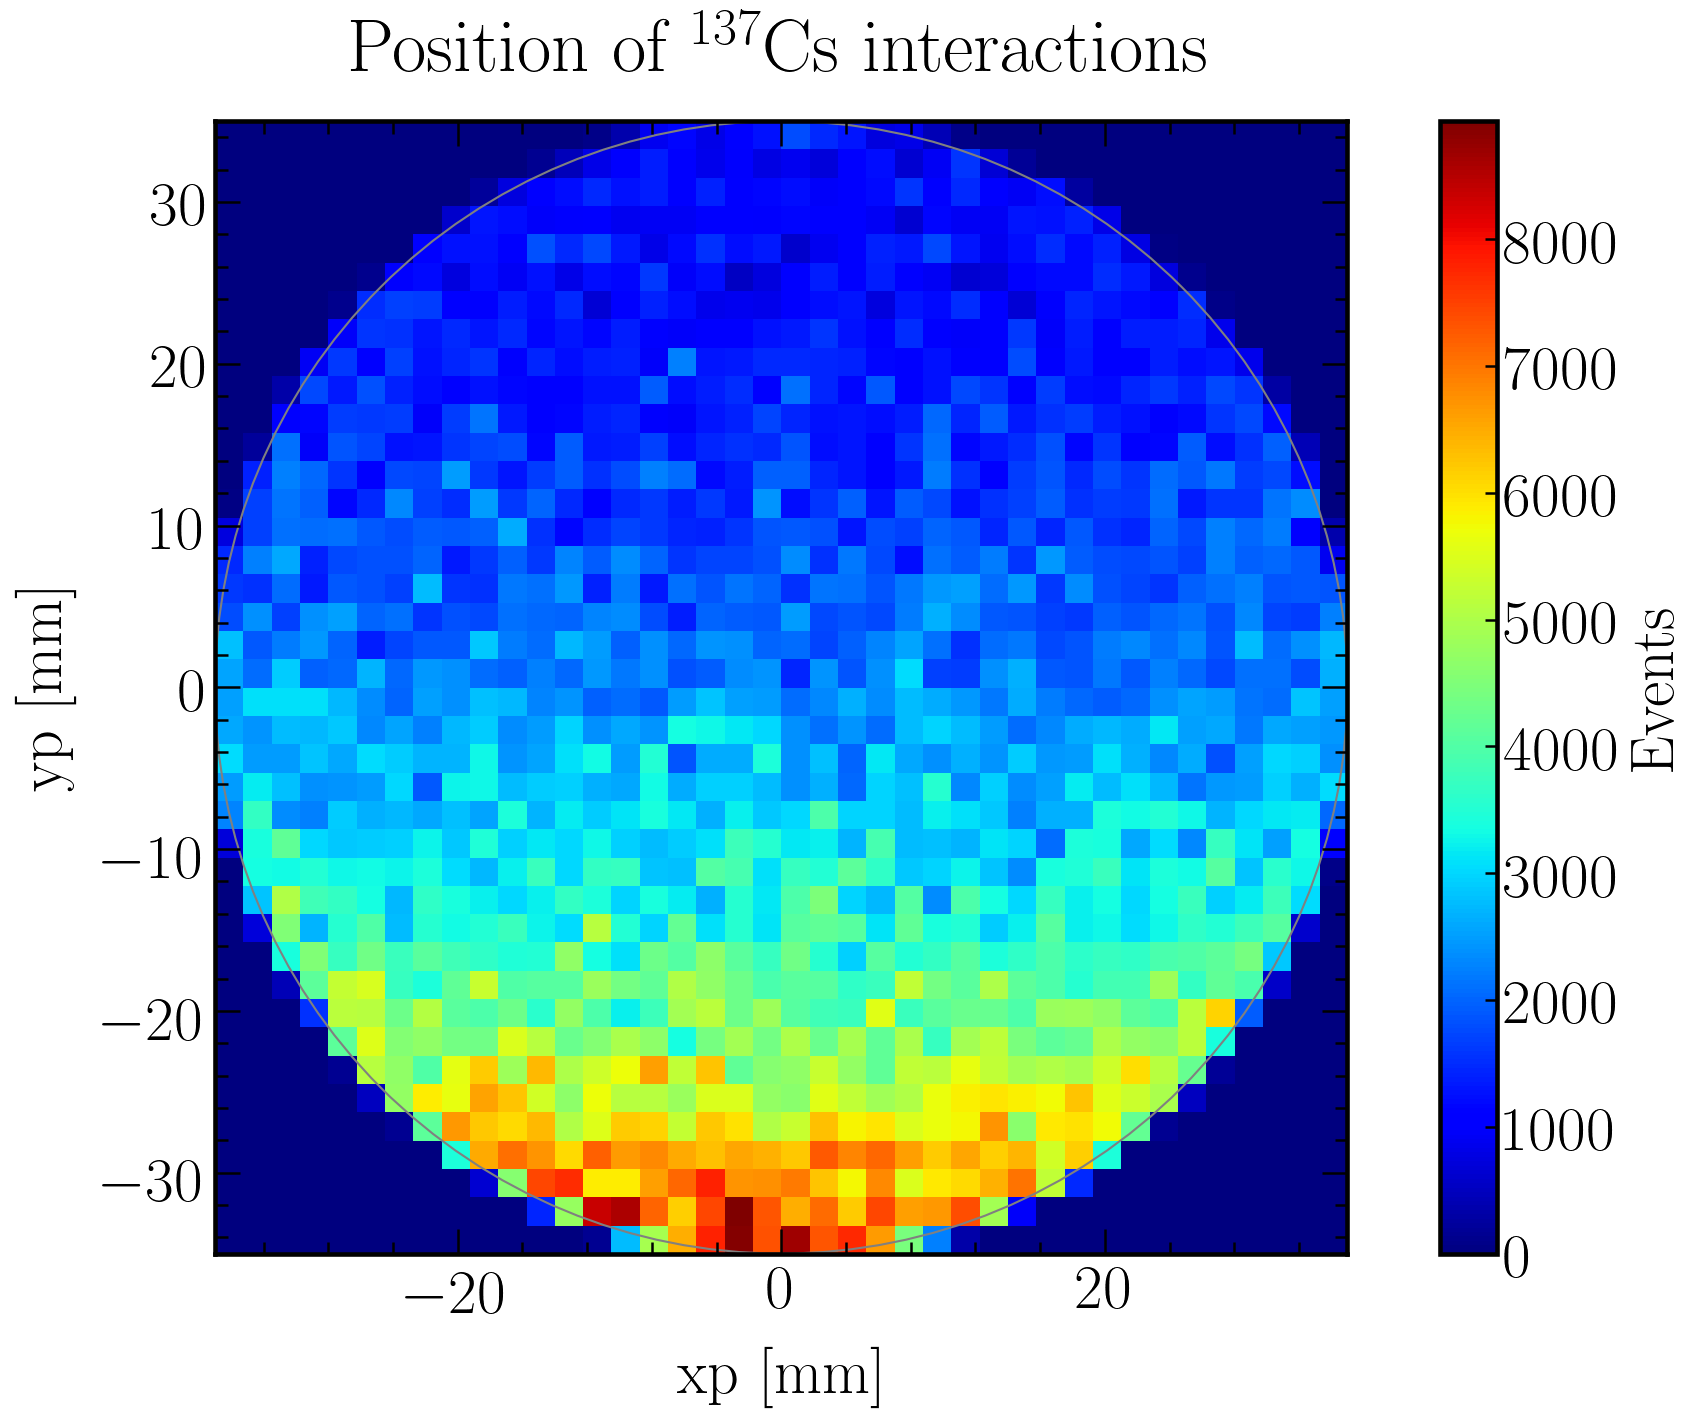

In [32]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(xp_flat, yp_flat, bins=40, cmap = 'jet')#, norm=LogNorm(), normed = True

plt.xlabel('xp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_xp_yp.png")

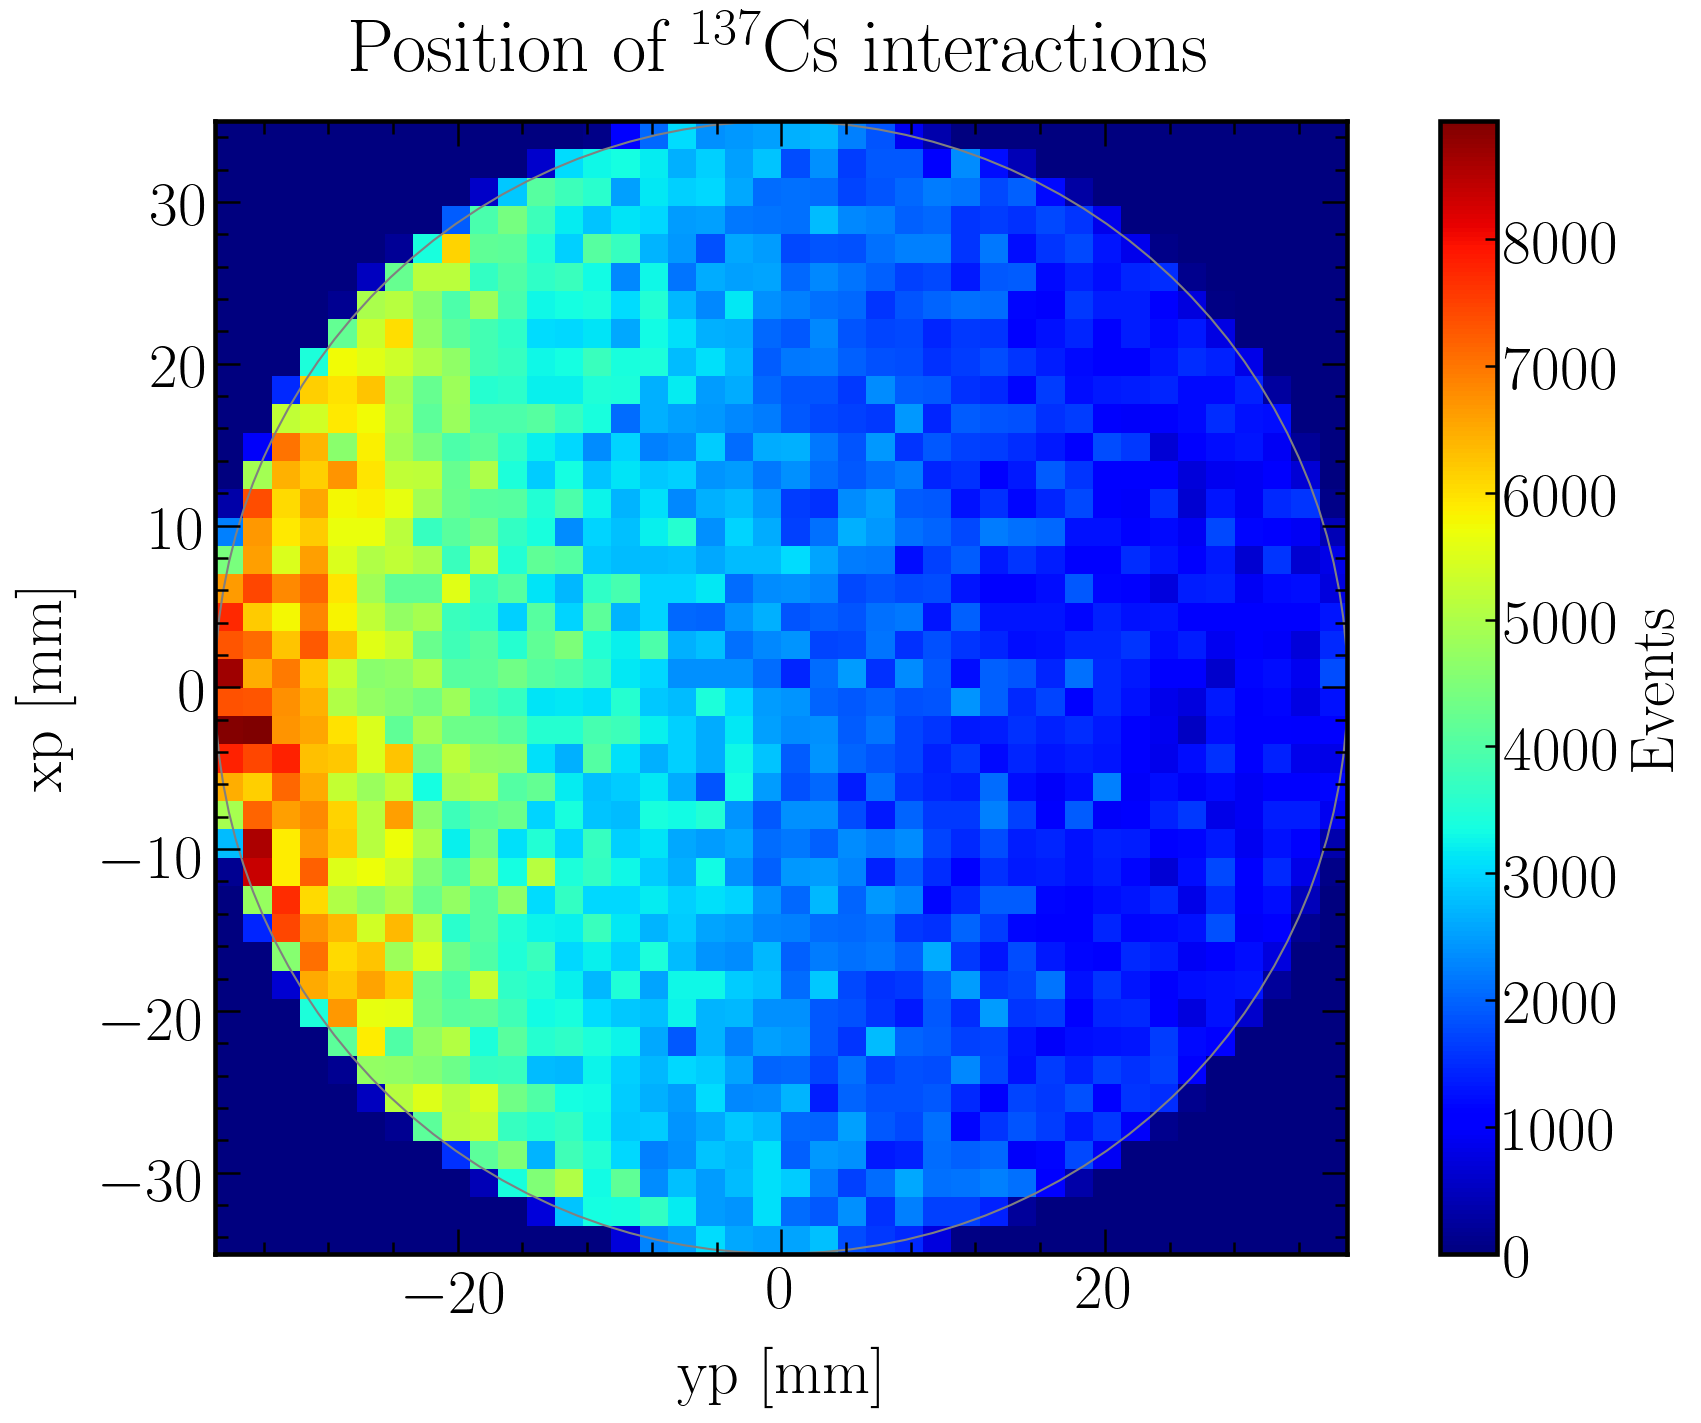

In [33]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(yp_flat, xp_flat, bins=40, cmap = 'jet')#, norm=LogNorm(), normed = True

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('xp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_xp.png")

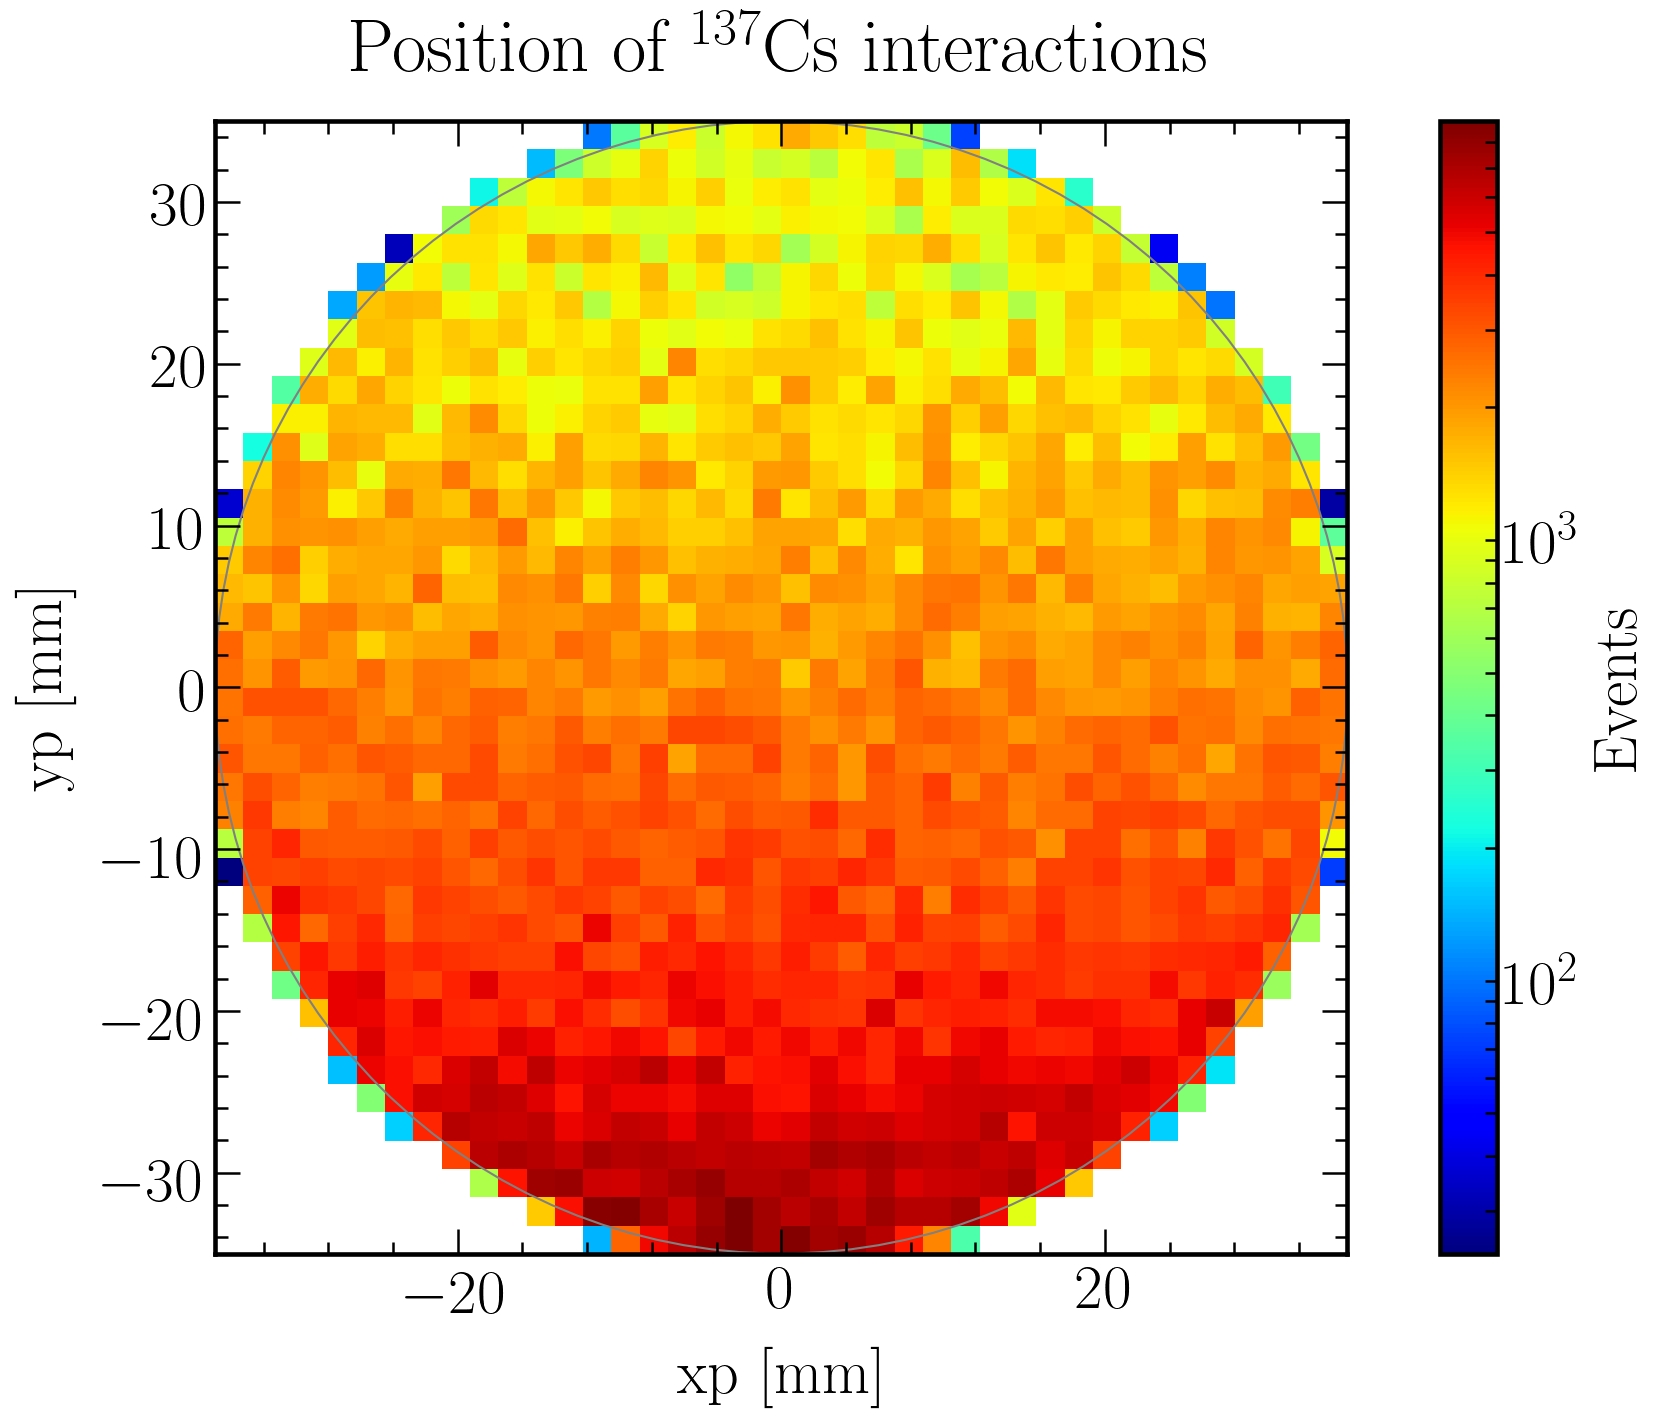

In [34]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.hist2d(xp_flat, yp_flat, bins=40, cmap = 'jet', norm=LogNorm())#, normed = True

plt.xlabel('xp [mm]', fontsize = label_size, labelpad = label_pad) # -35*mm,35*mm = 70
plt.ylabel('yp [mm]', fontsize = label_size, labelpad = label_pad) # 68.5*mm - 2*0.15*mm
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

plt.gca().set_aspect('equal', adjustable='box')

currentAxis = plt.gca()
circle = plt.Circle((0., 0.), 35., color='gray', linestyle = '-', fill=False)
currentAxis.add_artist(circle)

# Colorbar
cbar = plt.colorbar()
cbar.outline.set_linewidth(2.2)
cbar.ax.tick_params(direction='in', labelsize=label_size, width=1.2, length=6)
cbar.set_label(label='Events', fontsize=label_size) # Normalized 

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_xp_yp_log.png")

### Fit y-positions

In [35]:
x_slice_width = 3.; # half width slice x in mm
#y_slice_width = np.sqrt(35. * 35. - x_slice_width * x_slice_width)
y_slice_width = 20.

crits = (yp_flat <= y_slice_width)*(yp_flat >= -y_slice_width)*(xp_flat <= x_slice_width)*(xp_flat >= -x_slice_width)

yp_flat_slice = yp_flat[crits]
xp_flat_slice = xp_flat[crits]
ed_flat_slice = xp_flat[crits]

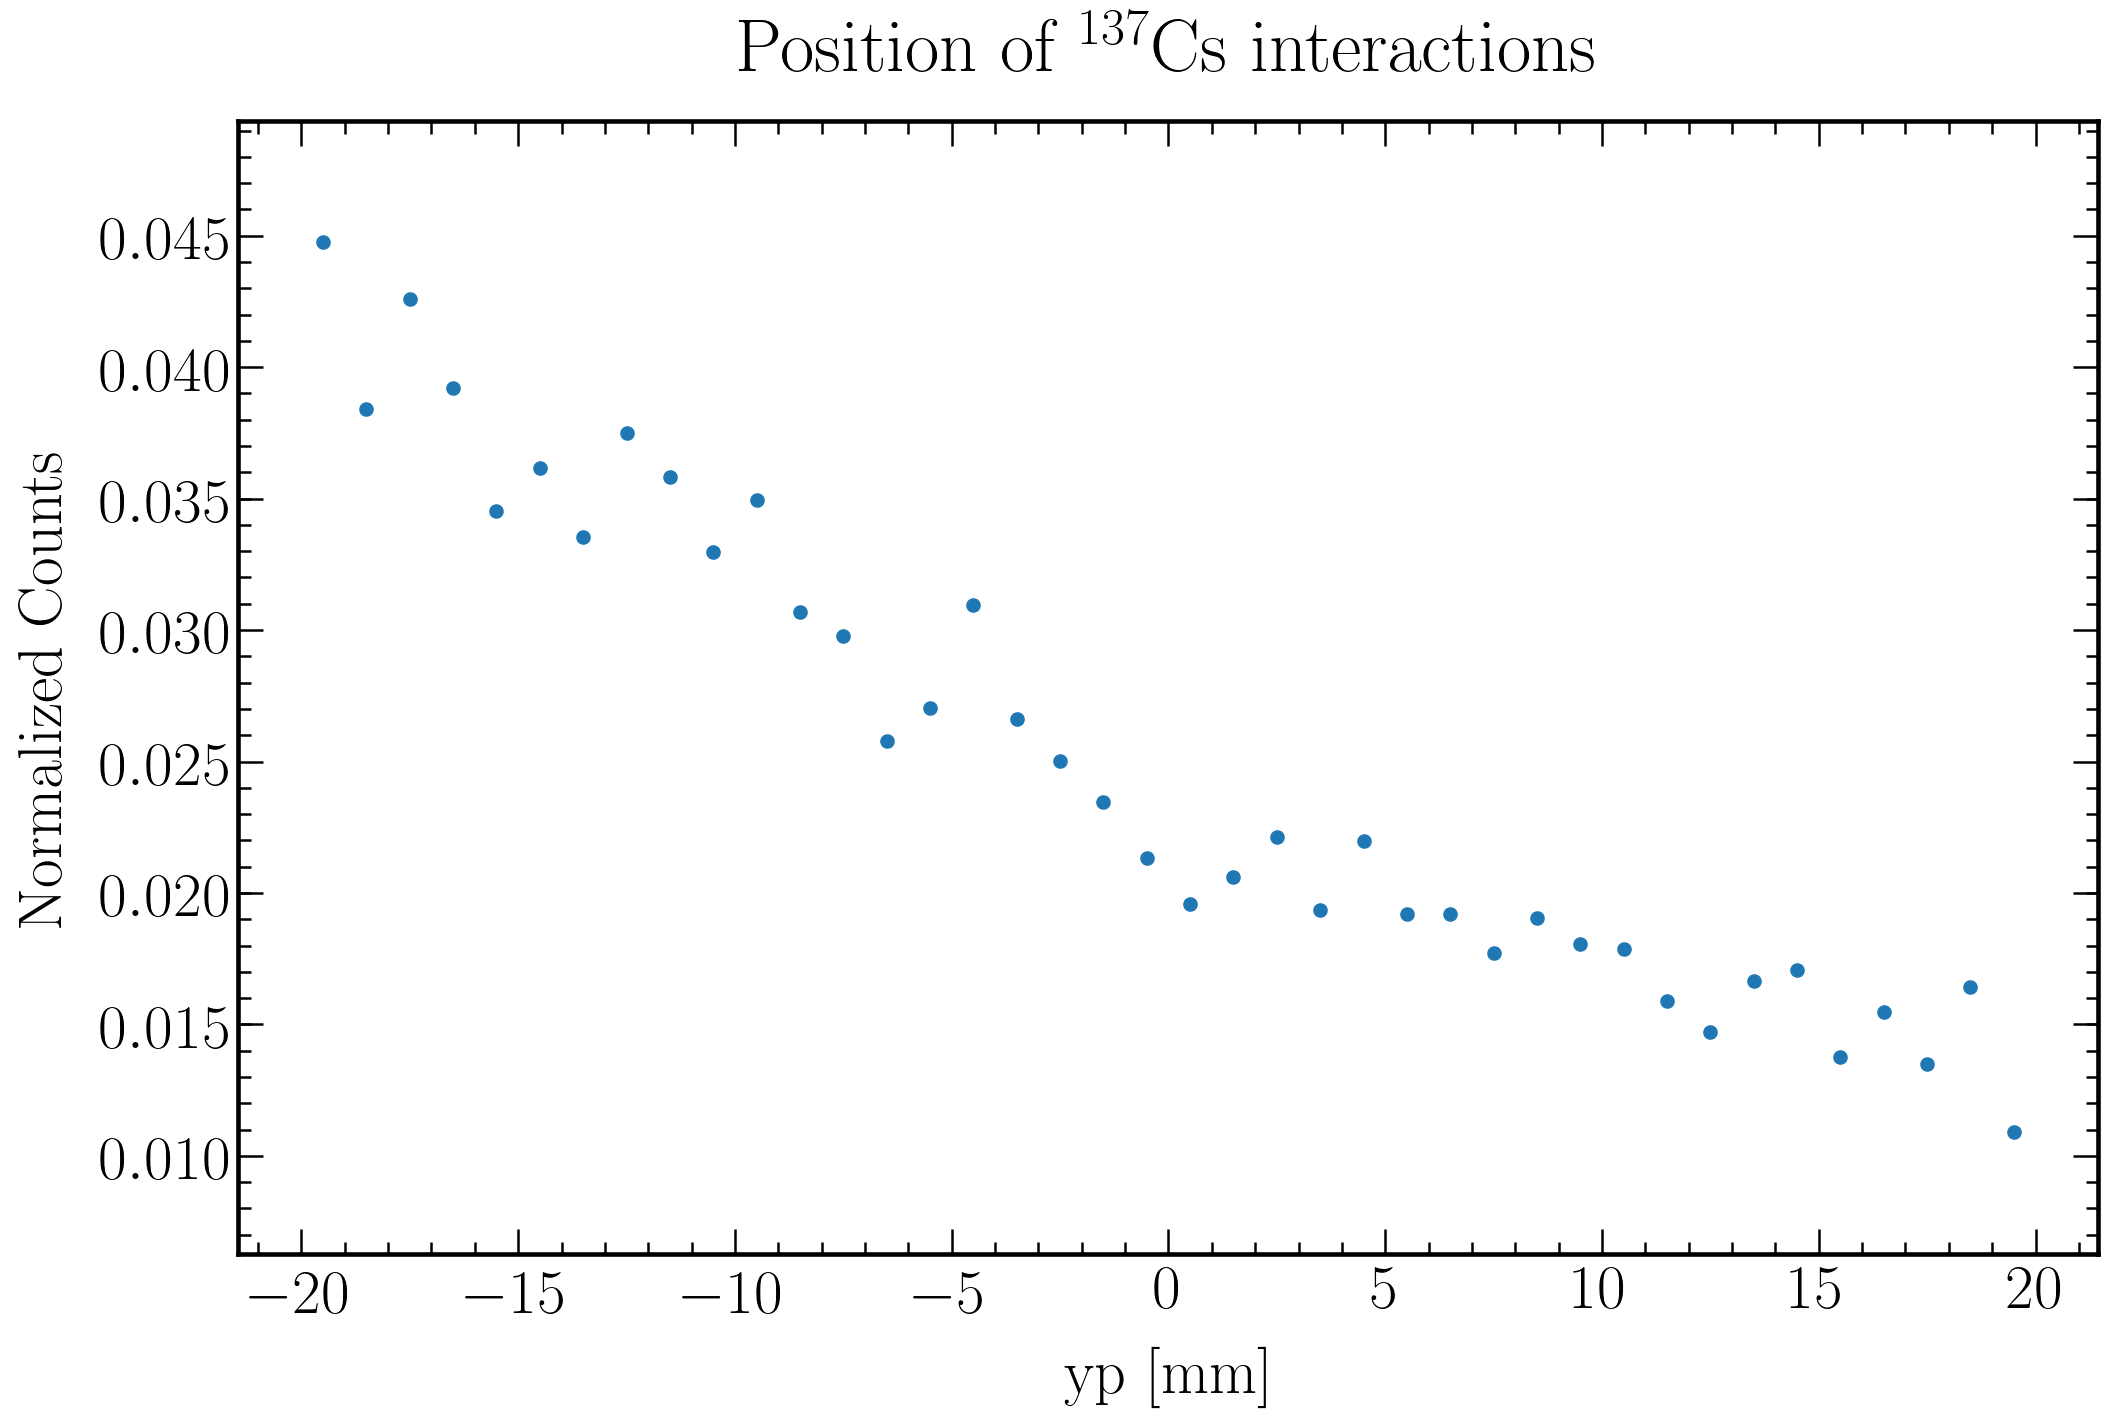

In [36]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
numberbins = 40

#n, bins, patches = plt.hist(yp_flat_slice, numberbins, facecolor='darkblue', histtype = 'step', linewidth = 2.2)

n_yp_flat_slice, bins_yp_flat_slice = np.histogram(yp_flat_slice, numberbins, density = True)
bins_center_yp_flat_slice = (bins_yp_flat_slice[:-1]+bins_yp_flat_slice[1:])/2
#plt.step(bins_center_yp_flat_slice, n_yp_flat_slice,where='mid',color='k',linestyle='--') # for normalization: /(len(yp_flat_slice)/numberbins)
plt.scatter(bins_center_yp_flat_slice, n_yp_flat_slice)

#plt.plot(bins_center_yp_flat_slice, func(bins_center_yp_flat_slice, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_slice.png")

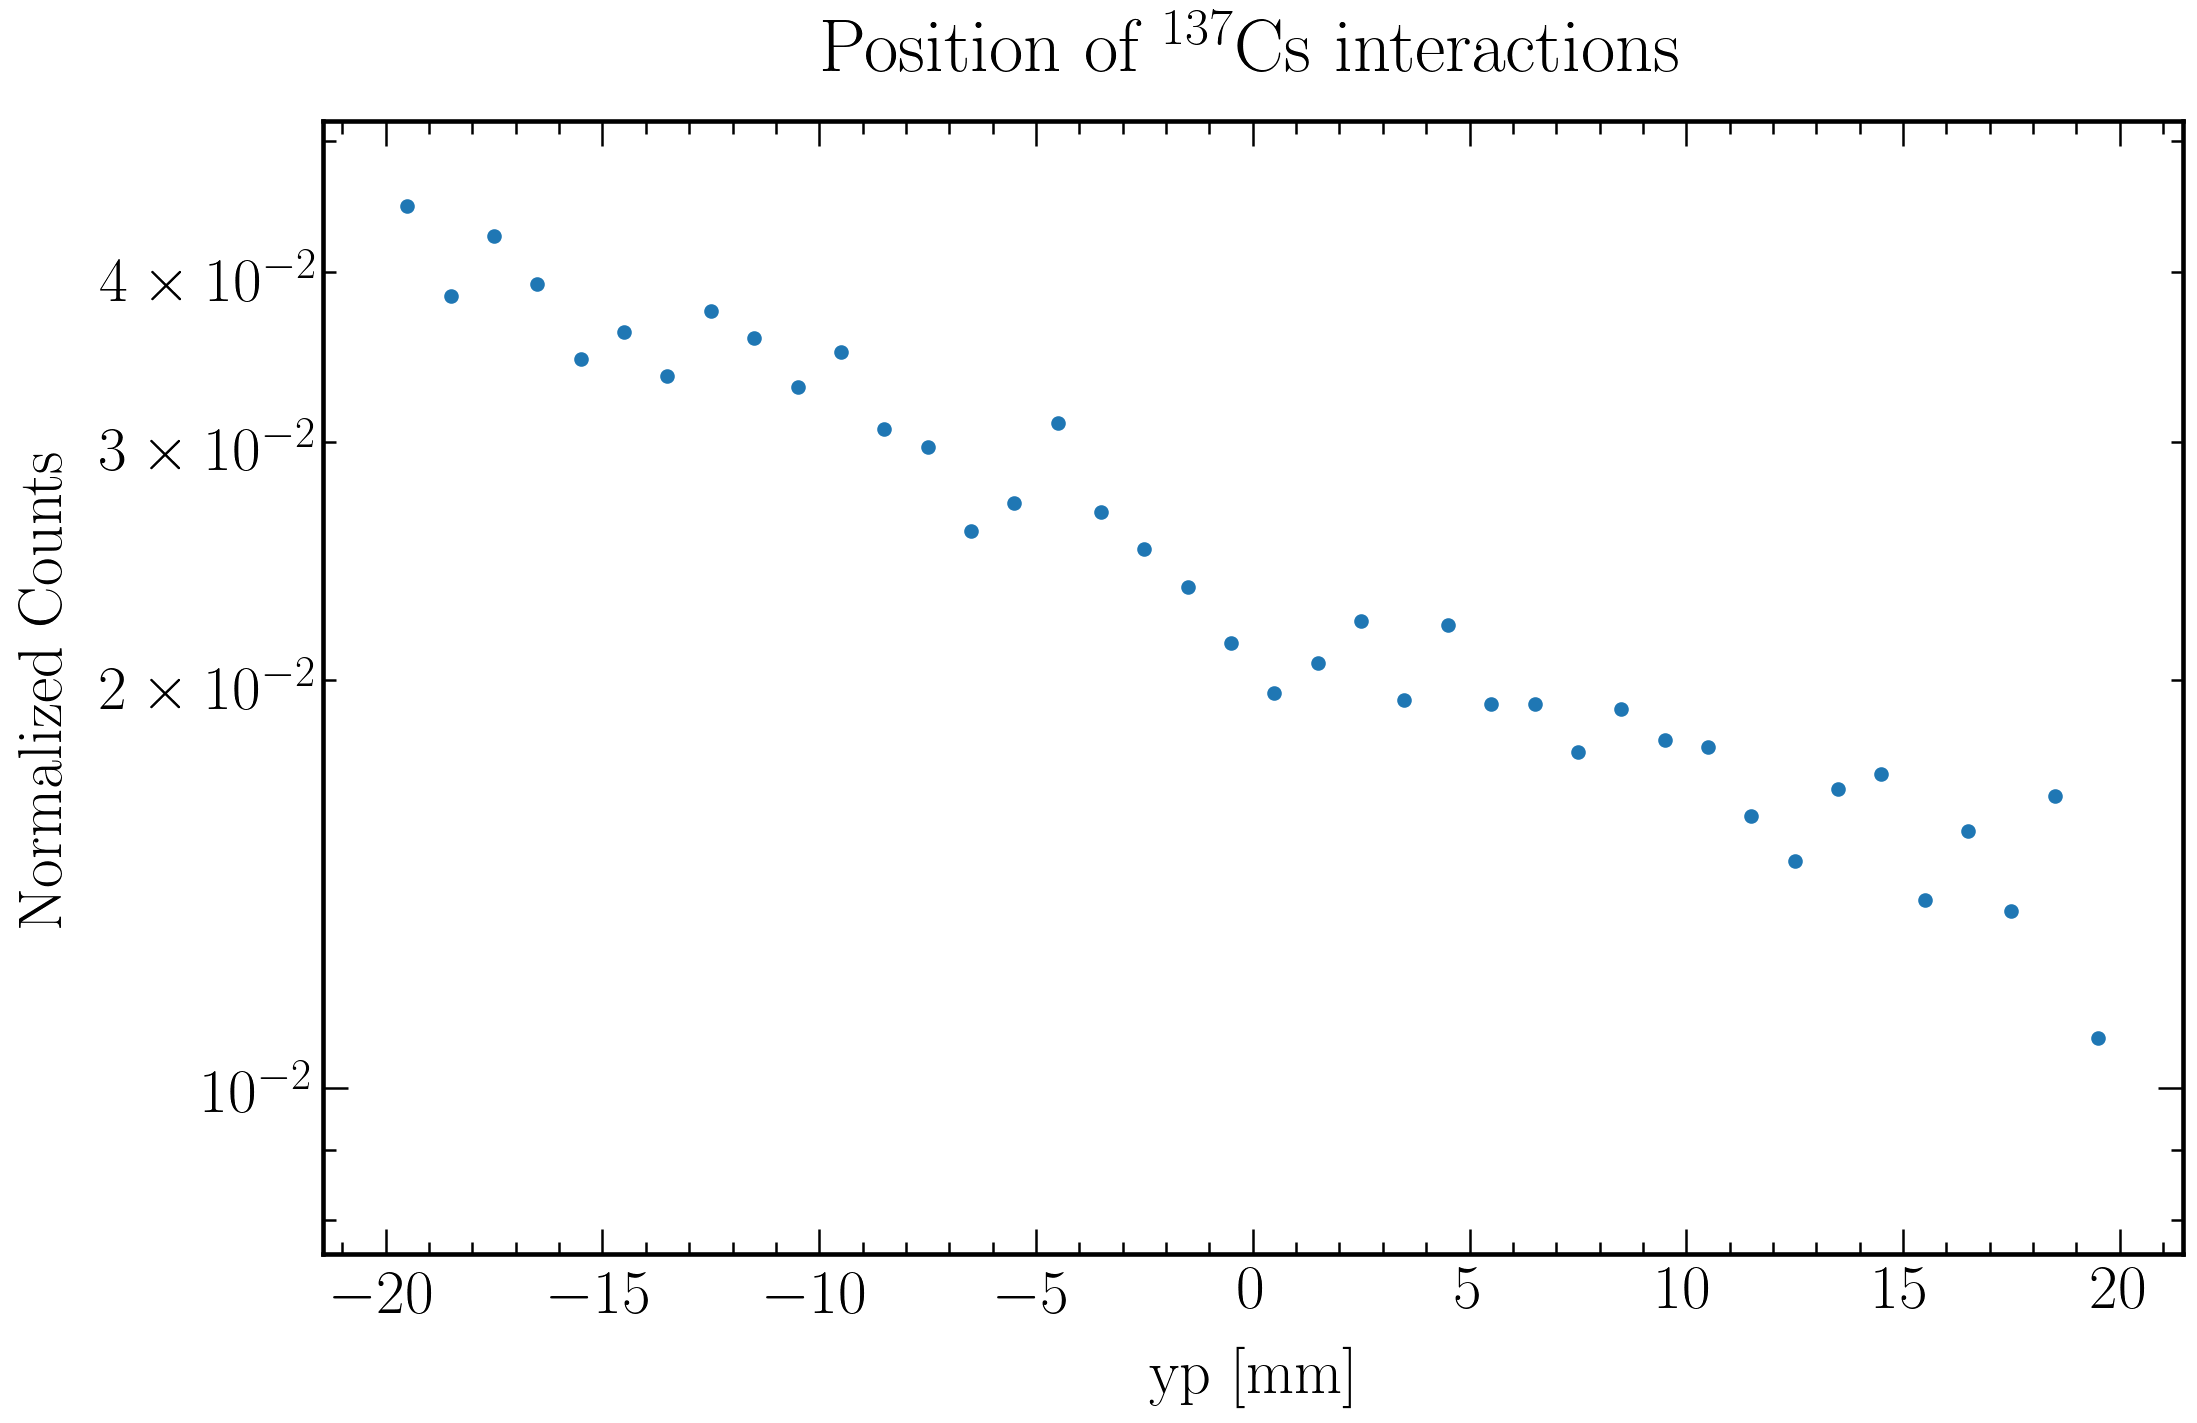

In [37]:
#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
plt.scatter(bins_center_yp_flat_slice, n_yp_flat_slice)

#plt.plot(bins_center_yp_flat_slice, func(bins_center_yp_flat_slice, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of '+isotope_name_fancy+' interactions', fontsize = title_size, pad = title_pad)

plt.yscale('log')

# Axes ---> Range
#plt.xlim(0,100) # 0 PE and 100 PE are typical values for the x axis limits
#plt.ylim(0,16000)
#plt.xlim(left=0)
#plt.yscale('log', nonposy='clip')

plt.show()

fig.savefig(filenameprefix+"_yp_spectrum_slice_log.png")

In [38]:
def func(x, a, b, c, d):
    return a * np.exp(-b * x - c) + d

#guess = np.array([2e4, 1, 1])

popt, pcov = curve_fit(func, bins_center_yp_flat_slice, n_yp_flat_slice) # , guess
popt

/home/ab602/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


array([1., 1., 1., 1.])

## Comparison of different files

In [39]:
## Available ROOT files in specified folder:
#! ls ../../Xebra_G4/*.root
#! ls ../../Analysis/Calibration_simulations_pointsource/data
! ls ../../Simulation_Data/Calibration_simulations_pointsource/*.root

ls: cannot access '../../Simulation_Data/Calibration_simulations_pointsource/*.root': No such file or directory


### Scintillation - no scintillation

In [40]:
'''## File 1

filename1 = '../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_noscint.root'

branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename1, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    
xp_pri1 = _chunk_collect.xp_pri
yp_pri1 = _chunk_collect.yp_pri
zp_pri1 = _chunk_collect.zp_pri
nevents1 = len(xp_pri1)
xp1 = _chunk_collect.xp
yp1 = _chunk_collect.yp
zp1 = _chunk_collect.zp
etot1 = _chunk_collect.etot
ed1 = _chunk_collect.ed
nsteps1 = _chunk_collect.nsteps

xp_flat1 = flatten_tuples(xp1)
yp_flat1 = flatten_tuples(yp1)
zp_flat1 = flatten_tuples(zp1)
rp_flat1 = np.sqrt(xp_flat1 * xp_flat1 + yp_flat1 * yp_flat1)
ed_flat1 = flatten_tuples(ed1)

try:
    del _chunk
    print("Deleted _chunk")
except NameError:
    print("Deleted _chunk (already done)")
    
try:
    del _chunk_collect
    print("Deleted _chunk_collect")
except NameError:
    print("Deleted _chunk_collect (already done)")''';

In [41]:
'''## File 1

filename2 = '../../Simulation_Data/Calibration_simulations_pointsource/Cs137_1e5_scint.root'

branches= ['xp_pri','yp_pri','zp_pri','xp','yp','zp','etot','ed','nsteps'] # Be careful that the branches are also initilized in _chunk_collect

import concurrent.futures
executor = concurrent.futures.ThreadPoolExecutor(8)

_chunk_collect = pd.DataFrame({'xp_pri' : [],'yp_pri' : [],'zp_pri' : [], 'xp' : [],'yp' : [],'zp' : [],'etot' : [],'ed' : [],'nsteps' : []}) # Initialize empty data frame

for _chunk in uproot.iterate(filename2, "events/events",branches, entrysteps=100000, 
                                       outputtype=pd.DataFrame, executor=executor):
    _chunk.columns=branches
    _chunk_collect = _chunk_collect.append(_chunk)
    
xp_pri2 = _chunk_collect.xp_pri
yp_pri2 = _chunk_collect.yp_pri
zp_pri2 = _chunk_collect.zp_pri
nevents2 = len(xp_pri2)
xp2 = _chunk_collect.xp
yp2 = _chunk_collect.yp
zp2 = _chunk_collect.zp
etot2 = _chunk_collect.etot
ed2 = _chunk_collect.ed
nsteps2 = _chunk_collect.nsteps

xp_flat2 = flatten_tuples(xp2)
yp_flat2 = flatten_tuples(yp2)
zp_flat2 = flatten_tuples(zp2)
rp_flat2 = np.sqrt(xp_flat2 * xp_flat2 + yp_flat2 * yp_flat2)
ed_flat2 = flatten_tuples(ed2)

try:
    del _chunk
    print("Deleted _chunk")
except NameError:
    print("Deleted _chunk (already done)")
    
try:
    del _chunk_collect
    print("Deleted _chunk_collect")
except NameError:
    print("Deleted _chunk_collect (already done)")''';

In [42]:
'''#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(etot1, 35, color='darkblue', histtype = 'step', linewidth = 2.2, label = 'no scintillation')# , density = True
n, bins, patches = plt.hist(etot2, 35, color='red', histtype = 'step', linewidth = 2.2, label = 'scintillation', linestyle = '--')# , density = True


plt.xlabel('E [keV]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Counts', fontsize = label_size, labelpad = label_pad) # Normalized 
plt.title('Simulated $^{137}$Cs spectrum from total deposited energy', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
plt.xlim(0,700)
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

leg = plt.legend(loc=2, bbox_to_anchor=(0.01,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig("Cs137_1e5_totalenergy_spectrum_comparison_scint.png")''';

In [43]:
'''#############################################
## Set plot styles:
#############################################

fig=plt.figure(figsize=(16, 10), dpi=150)

# Text options
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Labels
label_size = 30 #25
label_pad = 12 #10
title_size = 36 #30
title_pad = 24 #20

# Axes Parameters
axes = plt.gca()
axes.tick_params(axis='both') 

# Axes ---> Linewidth
for axis in ['top','bottom','left','right']:
    axes.spines[axis].set_linewidth(2.2)
    
# Axes ---> Ticks
axes.xaxis.set_minor_locator(AutoMinorLocator(5)) 
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
axes.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.tick_params(which='minor', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=6)
plt.tick_params(which='major', direction='in', labelsize=label_size, top=True, right=True, width=1.2, length=12)

# Grid
#plt.grid(True)
    
#############################################
## Plot specific settings and plot data
#############################################

# Data plot
n, bins, patches = plt.hist(yp_flat1, 35, color='darkblue', histtype = 'step', linewidth = 2.2, density = True, label = 'no scintillation')
n, bins, patches = plt.hist(yp_flat2, 35, color='red', histtype = 'step', linewidth = 2.2, density = True, label = 'scintillation', linestyle = '--')


plt.xlabel('yp [mm]', fontsize = label_size, labelpad = label_pad)
plt.ylabel('Normalized Counts', fontsize = label_size, labelpad = label_pad)
plt.title('Position of $^{137}$Cs interactions', fontsize = title_size, pad = title_pad)

# Axes ---> Shading an area or Drawing a vertica line
#axes.axvspan(662-10, 662+10, alpha=0.5, color='0.8')
#plt.axvline(662, alpha=0.5, color='grey')

# Axes ---> Range
#plt.xlim(0,700)
#plt.ylim(0,16000)
#plt.xlim(left=0)
plt.yscale('log', nonposy='clip')

leg = plt.legend(loc=1, bbox_to_anchor=(0.99,0.99), fontsize=0.9*label_size, frameon=True, shadow=False, edgecolor='black', fancybox=False)
for line in leg.get_lines(): # enumerated
    line.set_linewidth(4)
leg.get_frame().set_linewidth(2.5) 

plt.show()

fig.savefig("Cs137_1e5_yp_spectrum_comparison_scint.png")''';